# Making and Testing Dips 

In this notebook, we're going to simulate some dips

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import datetime

import lightkurve as lk
from dipper import measure_dip


Kyle has a basic function in his notebook that I think we can extend:

In [2]:
def dip(time, depth, tdip, width, mean_flux=1):
    """
    Function to generate the flux for a dip and surrounding
    flat light curve, given a set of time stamps.

    Parameters
    ----------
    depth : float, or iterable
        A value or list of values for the depth(s) of the dip(s)

    tdip : float, or iterable
        A value or list of values for the location(s) of the dip(s)

    width : float, or iterable
        A value or list of values for the width(s) of the dip(s)

    mean_flux : float, default 1
        The constant flux of the star

    Returns
    -------
    flux : numpy.ndarray
        An array of flux values corresponding to the time stamps
        in `time`

    """
    time = np.array(time)

    # make flux
    if np.size(depth) > 1:
        flux = mean_flux
        for i in range(len(depth)):
            flux -= depth[i] * np.exp(-(time-tdip[i])**2 / (2 * width[i]**2))
    else:
        flux = mean_flux - depth * np.exp(-(time-tdip)**2 / (2 * width**2))

    return flux

In [3]:
def simulate_dip_flux(tseg=851, coverage=3.0, width=5, depth=0.2, tdip="random"):
    """
    Simulate normalized flux for one or multiple dips on an evenly sampled 
    grid.
    
    Parameters
    ----------
    tseg : float
        The duration of the total light curve in days
    
    coverage : float
        The number of data points per day in the finely 
        sampled light curve.
        
    width : float, or iterable
        The width of the dip in days
        
    depth : float [0,1], or iterable
        The depth of the dip, as a fraction of the flux normalized to 1. 
        Must be between 0 and 1
    
    tdip : float or None or "random"
        If no dip position is given in the time unit of the light curve, 
        either the dip is put in the middle (or equally spaced for multiple dips), if None, 
        or the position is randomized across the light curve (for "random") 
        
        
    Returns
    -------
    time : numpy.ndarray
        An array with time stamps for the flux measurements
        
    flux : numpy.ndarray
        An array with the flux measurements
    
    """
    # if my width and depth are numbers, I want to turn them 
    # into arrays so I can loop over them and won't need to 
    # treat that case separately later
    if np.size(width) == 1:
        width = np.array([width])
    if np.size(depth) == 1:
        depth = np.array([depth])

    # if tdip is None, then randomly scatter dip into the 
    # light curve, otherwise make sure it's an array
    if tdip is not None and tdip != "random":
        if np.size(tdip) == 1:
            tdip = np.array([tdip])
    elif tdip == "random":
        w = np.max(width) * 5.0
        tdip = np.random.uniform(0+w, tseg-w, size=len(width))
    else:
        if np.size(width) == 1:
            tdip = np.array([tseg/2.0])
        # if there's more than one dip, scatter through light curve
        # at regular intervals
        else:
            w = np.max(width) * 5.0
            tdip = np.linspace(w, tseg-w, len(width))
            
    # check that inputs are correct
    if np.any(width >= tseg):
        raise ValueError("The dip must be smaller than the length of the light curve.")

    # check that the depth is smaller than 1, or we'll have negative flux
    if np.any(depth >= 1.0):
        raise ValueError("The depth of the dip must be < 1.")

    # the number of points is the days times the coverage:
    npoints = int(tseg * coverage)

    # create evenly sampled time array
    time = np.linspace(0.0, tseg, npoints)

    # calculate_flux
    flux = dip(time, depth, tdip, width, mean_flux=1)

    return time, flux

Let's simulate a light curve and see what it looks like.

We need the total duration of the ZTF survey:

In [4]:
# ZTF First Light
ztf_start = datetime.date(2017, 11, 1)

# Pick a recent date
today = datetime.date(2020, 3, 1)

# difference in days
tseg = today - ztf_start
tseg = tseg.days

In [5]:
coverage = 5
width = 5.0
depth = 0.2

np.random.seed(400)

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)


Okay, cool, now we want to generate light curves:

In [7]:
def simulate_lightcurves_from_fluxes(time, flux, nbands=1, cadence=None, npoints=None,
                         err=0.02, mean_mag=12.0):

    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")
    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
    if np.size(err) == 1:
        err = np.array([err])
    if np.size(npoints) == 1:
        npoints = np.array([npoints])
    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])

    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            idx = np.sort(np.random.choice(np.arange(time.shape[0]), replace=False, size=npoints[i]))
        else:
            cad = cadence[i]
            idx = time.searchsorted(cad)

        new_time = time[idx]
        new_flux = flux[idx]

        mag = -2.5*np.log10(new_flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]

        lc = lk.LightCurve(time=new_time,
                                   flux=mag,
                                   flux_err=magerr)
        lc_all.append(lc)

    return lc_all


In [8]:
def simulate_lightcurves_from_function(width, depth, tdip="random",  tseg=851, nbands=1, cadence=None, npoints=None,
                         err=0.02, mean_mag=12.0):

    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
    
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")
    
    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
    
    if np.size(err) == 1:
        err = np.array([err])
    
    if np.size(npoints) == 1:
        npoints = np.array([npoints])
    
    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])

    if np.size(width) == 1:
        width = np.array([width])
    if np.size(depth) == 1:
        depth = np.array([depth])

    # if tdip is None, then randomly scatter dip into the 
    # light curve, otherwise make sure it's an array
    if tdip is not None and tdip != "random":
        if np.size(tdip) == 1:
            tdip = np.array([tdip])
    elif tdip == "random":
        w = np.max(width) * 5.0
        tdip = np.random.uniform(0+w, tseg-w, size=len(width))
    else:
        if np.size(width) == 1:
            tdip = np.array([tseg/2.0])
        # if there's more than one dip, scatter through light curve
        # at regular intervals
        else:
            w = np.max(width) * 5.0
            tdip = np.linspace(w, tseg-w, len(width))

    # check that inputs are correct
    if np.any(width >= tseg):
        raise ValueError("The dip must be smaller than the length of the light curve.")

    # check that the depth is smaller than 1, or we'll have negative flux
    if np.any(depth >= 1.0):
        raise ValueError("The depth of the dip must be < 1.")

    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            time = np.random.uniform(0, tseg, size=npoints[i])

        else:
            time = np.array(cadence[i])

        
        flux = dip(time, depth, tdip, width, mean_flux=1.0)

        mag = -2.5*np.log10(flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]

        lc = lk.LightCurve(time=time,
                           flux=mag,
                                   flux_err=magerr)
        lc_all.append(lc)

    return lc_all


Now we can generate an actual light curve from a single band:

In [9]:
np.random.seed(200)
lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )

Let's do the same with the function that samples directly from the function:

In [10]:
lc_all = simulate_lightcurves_from_function(width, depth, tdip=tseg/2, tseg=851, nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

(12.31830459643757, 11.913164243808989)

Ok, cool, let's simulate a bunch of these:

In [12]:
nsims = 20

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for i in range(nsims):
    
    lc_all = simulate_lightcurves_from_function(width, depth, tdip=tseg/2, tseg=tseg, 
                                                nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )
    ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", 
                color="black", markersize=4, alpha=0.2)

#ax.set_xlim(470, 530)
ax.set_ylim(ax.get_ylim()[::-1])

(12.304880800246064, 11.878706824017266)

### Simulating multiple dips

Let's try simulating three dips, to figure out how that works:

In [13]:
coverage = 10
width = np.array([5.0, 10.0, 7.0])
depth = np.array([0.2, 0.5, 0.1])

In [14]:
np.random.seed(1000)
time, flux = simulate_dip_flux(tseg, coverage, width, depth)

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)

Ok, cool: let's make this into an actual light curve:

In [16]:
np.random.seed(200)
lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=1, npoints=[400], err=0.02, mean_mag=12.0 )

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

(12.796337538786094, 11.886751721660895)

Excellent, that works. Now we really want to generate multiple bands:

In [17]:
np.random.seed(400)
lc_all = simulate_lightcurves_from_fluxes(time, flux, nbands=3, npoints=[400, 600, 100], 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

(13.950336396001095, 11.825920542128662)

Okay, so that seems to work, too. 

Let's decide some actual cadences:

In [18]:
c1 = np.sort(np.random.uniform(0, tseg, 100))
c2 = np.sort(np.random.uniform(0, tseg, 800))
c3 = np.sort(np.random.uniform(0, tseg, 300))

cadences = np.array([c1, c2, c3])

np.random.seed(1000)
lc_all = simulate_lightcurves_from_function(width, depth, nbands=3, cadence=cadences, 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

(14.029879602088839, 11.825649139018777)

Hooray, that works, too. 

### Importing ZTF Cadences

Now we can import ZTF cadences and errors and hopefully start making realistic light curves:

In [19]:
datadir = "/epyc/data/boyajian/"

pickle_file = "sample_mjds_2.pkl"

In [20]:
ztf_cadence = pd.read_pickle(datadir + pickle_file)

In [21]:
ztf_cadence.head()

,mjd_g,mag_g,magerr_g,mjd_r,mag_r,magerr_r
0,"[58204.201331, 58206.1338889, 58450.4353819, 5...","[18.049786, 17.98969, 17.893917, 17.893661, 17...","[0.043785494, 0.042514425, 0.04061343, 0.04060...","[58475.45729171111, 58450.3772454, 58475.45774...","[17.445889, 17.433268, 17.45091, 17.46019, 17....","[0.029131362, 0.029901987, 0.029236319, 0.0294..."
1,"[58208.4476505, 58208.4842824, 58234.3558912, ...","[16.587982, 16.418648, 16.603691, 16.678661, 1...","[0.027895203, 0.027219111, 0.02796397, 0.02830...","[58502.56362271111, 58502.56866901111, 58502.5...","[15.69869, 15.667656, 15.66051, 15.677812, 15....","[0.012726132, 0.012664719, 0.012650874, 0.0148..."
2,"[58598.42826391111, 58598.42871531111, 58246.3...","[20.503447, 20.104498, 20.468098, 20.198317, 2...","[0.1468122, 0.12067488, 0.120341174, 0.1270227...","[58694.26076391111, 58723.21578701111, 58217.4...","[19.5084, 19.513474, 19.416594, 19.455902, 19....","[0.08006927, 0.08037927, 0.08319566, 0.0769301..."
3,"[58205.4712847, 58246.3551505, 58728.162881911...","[19.52711, 19.600018, 19.734375, 19.756207, 19...","[0.07429419, 0.07745236, 0.097713016, 0.084637...","[58694.26076391111, 58723.21578701111, 58666.3...","[18.070387, 18.075138, 18.075306, 18.28212, 18...","[0.029745415, 0.029832937, 0.029836038, 0.0340..."
4,"[58599.37923613333, 58235.417419, 58274.377963...","[20.6547, 19.874813, 20.611324, 20.21209, 20.3...","[0.14792758, 0.09857254, 0.13027763, 0.1135262...","[58700.21489581111, 58686.27434031111, 58700.2...","[19.047123, 19.245966, 19.162663, 19.18438, 19...","[0.06769094, 0.07629721, 0.07256523, 0.0735206..."


I have a function that returns data from that table in a dictionary:

In [22]:
def get_ztf_lightcurve(ztf_df, idx):
    """
    Get a dictionary with ZTF points in r and g bands out 
    of the cadence data frame
    
    Parameters
    ----------
    ztf_df : pd.DataFrame
        A DataFrame with the ZTF data, has columns `mjd_g`, `mag_g`, 
        `magerr_g`, `mjd_r`, `mag_r`, `magerr_r`
        
    idx: int
        An index in ztf_df.index to choose a particular light curve
        
    Returns
    -------
    ztf_lc : dict
        A dictionary with the data in a given row of the DataFrame
    """
    ztf_line = ztf_df.loc[idx]
    # get out data in g-band
    mjd_g = ztf_line[0]
    mag_g = ztf_line[1]
    magerr_g = ztf_line[2]
    # select only "good" observations with 
    # the magnitude error > 0
    good_g = magerr_g > 0.0
    mjd_g = mjd_g[good_g]
    mag_g = mag_g[good_g]
    magerr_g = magerr_g[good_g]
    # make sure data is sorted in time
    g_idx = np.argsort(mjd_g)
    mjd_g = mjd_g[g_idx]
    mag_g = mag_g[g_idx]
    magerr_g = magerr_g[g_idx]

    # get out r-band data
    mjd_r = ztf_line[3]
    mag_r = ztf_line[4]
    magerr_r = ztf_line[5]
    # pick only data points with good errors
    good_r = magerr_r > 0.0
    mjd_r = mjd_r[good_r]
    mag_r = mag_r[good_r]
    magerr_r = magerr_r[good_r]
    # sort in time
    r_idx = np.argsort(mjd_r)
    mjd_r = mjd_r[r_idx]
    mag_r = mag_r[r_idx]
    magerr_r = magerr_r[r_idx]

    tseg_g = mjd_g.max() - mjd_g.min()
    tseg_r = mjd_r.max() - mjd_r.min()

    ztf_lc = {"mjd_g": mjd_g, "mag_g": mag_g, "magerr_g": magerr_g,
              "mjd_r": mjd_r, "mag_r": mag_r, "magerr_r": magerr_r,
              "meanmag_g": np.mean(mag_g), "meanmag_r": np.mean(mag_r),
              "tseg_g": tseg_g, "tseg_r": tseg_r,
              "ng": len(mjd_g), "nr": len(mjd_r),
              "zero_g": mjd_g[0], "zero_r":mjd_r[0]}

    return ztf_lc




In [23]:
ztf_lc = get_ztf_lightcurve(ztf_cadence, 10)

In [24]:
print("Total length in g band: " + str(ztf_lc["tseg_g"]))
print("Total length in r band: " + str(ztf_lc["tseg_r"]))

Total length in g band: 153.6687963000004
Total length in r band: 451.8157986111037


Now I can hopefully stick that cadence into my simulated dips:

In [27]:
c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"]
c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"]

cadences = np.array([c1, c2])
nbands = 2
mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
err = np.array([ztf_lc["magerr_g"], ztf_lc["magerr_r"]])

np.random.seed(1000)
lc_all = simulate_lightcurves_from_function(depth=0.3, width=4, nbands=nbands, cadence=cadences, 
                              err=err, mean_mag=mean_mag)

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

(20.801179830765072, 19.450358979355983)

Well, that' plots a thing!

## Simulate 1 Dip, Same Depth + Width

Let's start by simulating a single dip with the same depth and width:

In [170]:
width = 5.0
depth = 0.5

coverage = 5

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

Before we do this on the ZTF cadences, I want to get a feeling for how high the relevant scores should be from the dip detection function:

In [171]:
npoints = [100, 200, 500, 1000]
nsims = 1000

lc_sims_all = []
res_sims_all = []
for npts in npoints:
    lc_sims = []
    res_sims = []
    for i in range(nsims):
        lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=np.array([npts]), err=0.02, mean_mag=12.0)
        t_all = [lc.time for lc in lc_all]
        mag_all = [lc.flux for lc in lc_all]
        magerr_all = [lc.flux_err for lc in lc_all]

        res = measure_dip(t_all, mag_all, magerr_all)
        lc_sims.append(lc_all[0])
        res_sims.append(res)
    lc_sims_all.append(lc_sims)
    res_sims_all.append(res_sims)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


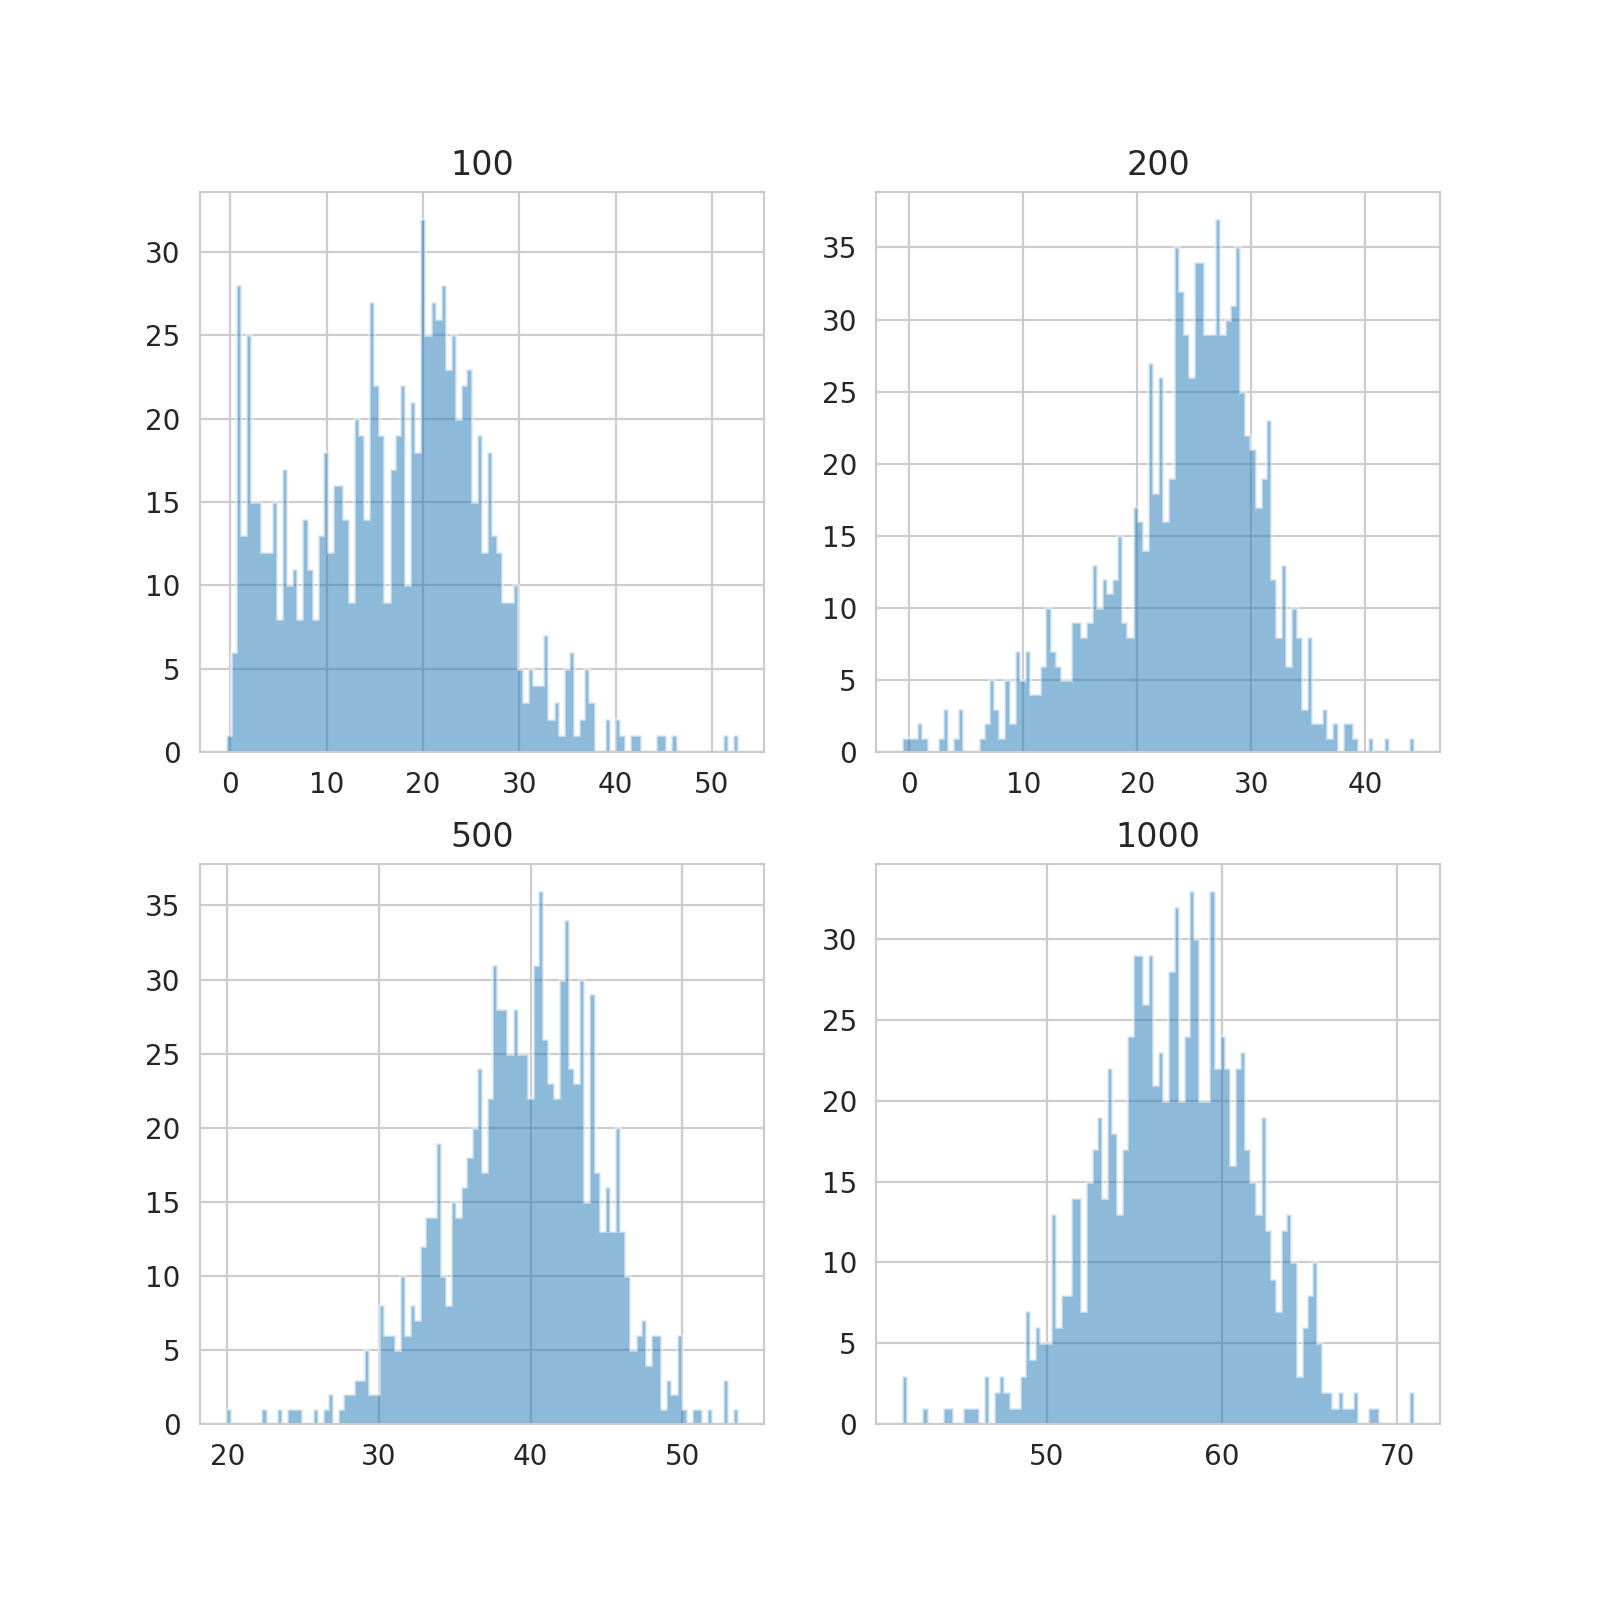

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

axes = np.hstack(axes)

for i in range(len(res_sims_all)):
    res_sims = res_sims_all[i]
    sig_sims = np.array([res["significance"] for res in res_sims])
    axes[i].hist(sig_sims, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(npoints[i])

All right, that's useful to know. Let's now take a look at the ZTF cadences:

In [181]:
nztf = len(ztf_cadence)

In [182]:
idx_all = np.random.randint(0, nztf, size=100)

In [183]:
lc_sim_all = []

idx_all = np.random.randint(0, nztf, size=10000)
for idx in idx_all:
    ztf_lc = get_ztf_lightcurve(ztf_cadence, idx)
    max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
    min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])
    
    max_start = tseg - max_time
    
    tstart = np.random.uniform(0, max_start, size=1)
    
    c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
    c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

    cadences = np.array([c1, c2])
    nbands = 2
    mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
    magerr_g = ztf_lc["magerr_g"]
    magerr_r = ztf_lc["magerr_r"]
    magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
    magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
    err = np.array([magerr_g, magerr_r])
    
    lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                                  err=err, mean_mag=mean_mag)

    lc_sim_all.append(lc_all)


Now let's try to look for dips using Kyle's code:

In [184]:
from dipper import measure_dip

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


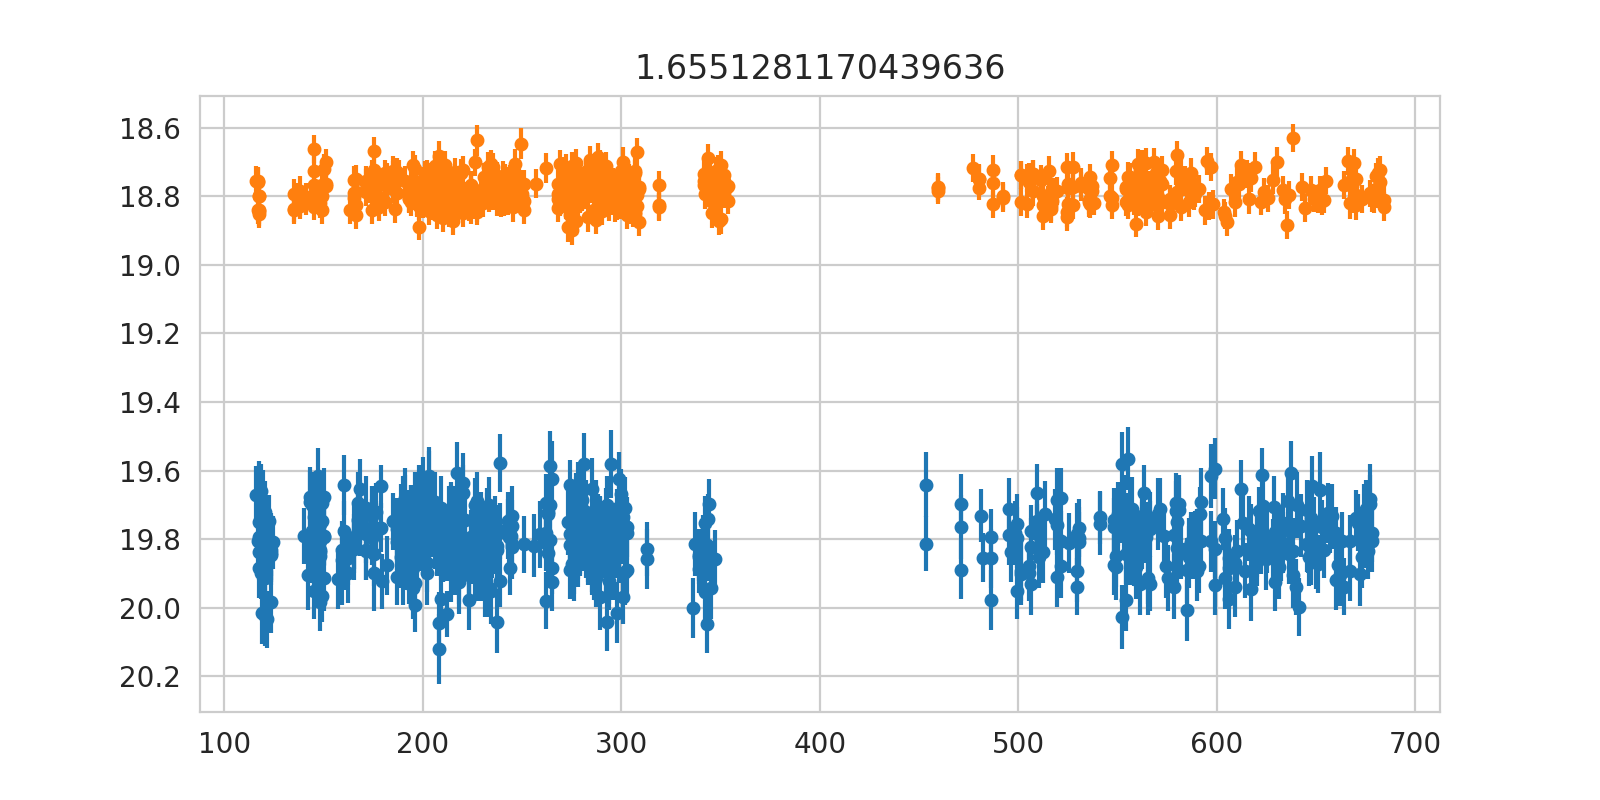

<IPython.core.display.Javascript object>


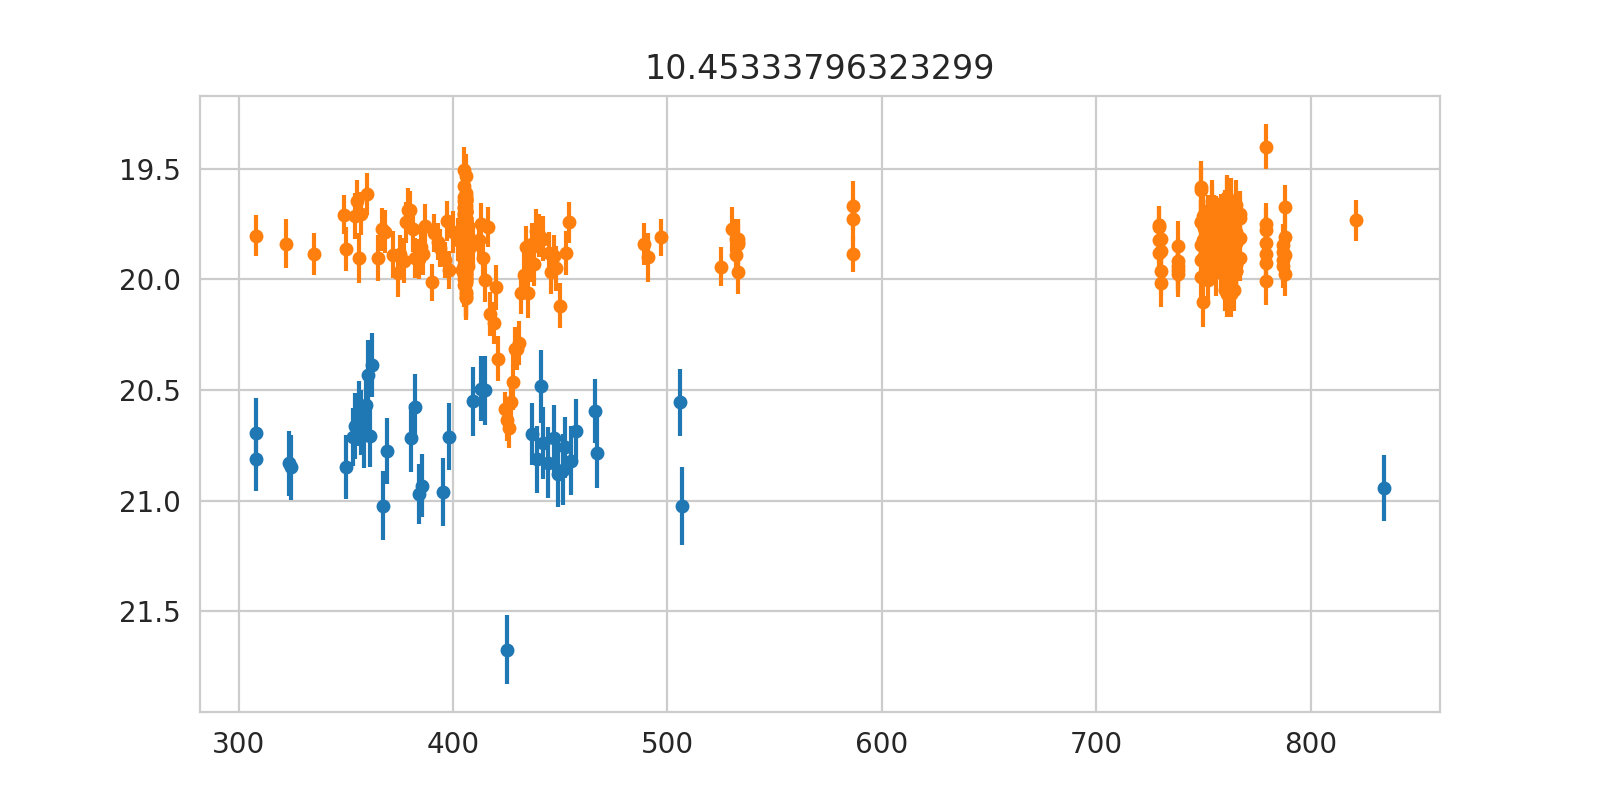

<IPython.core.display.Javascript object>


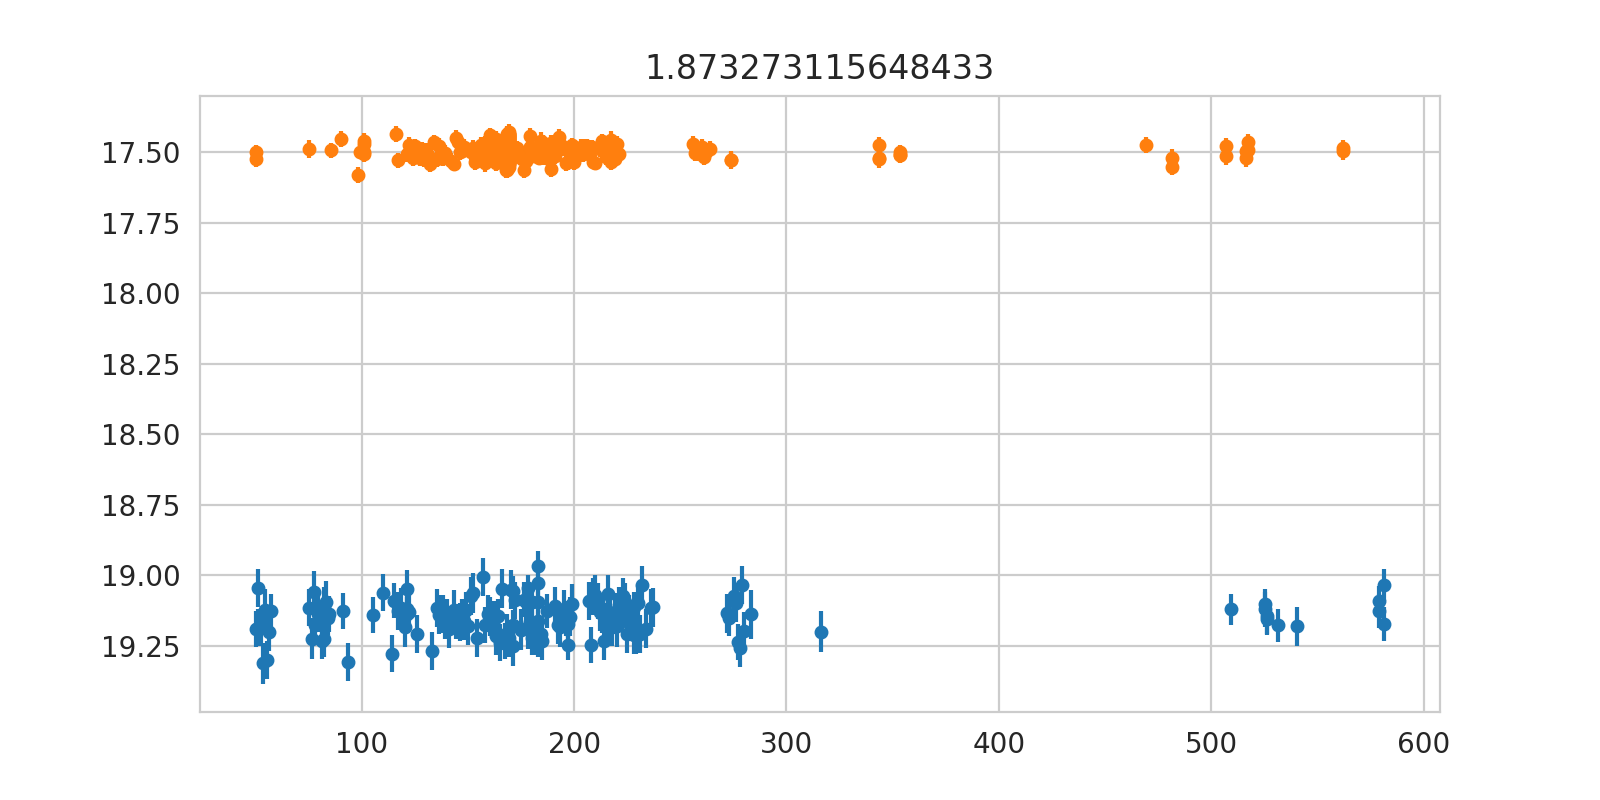

<IPython.core.display.Javascript object>


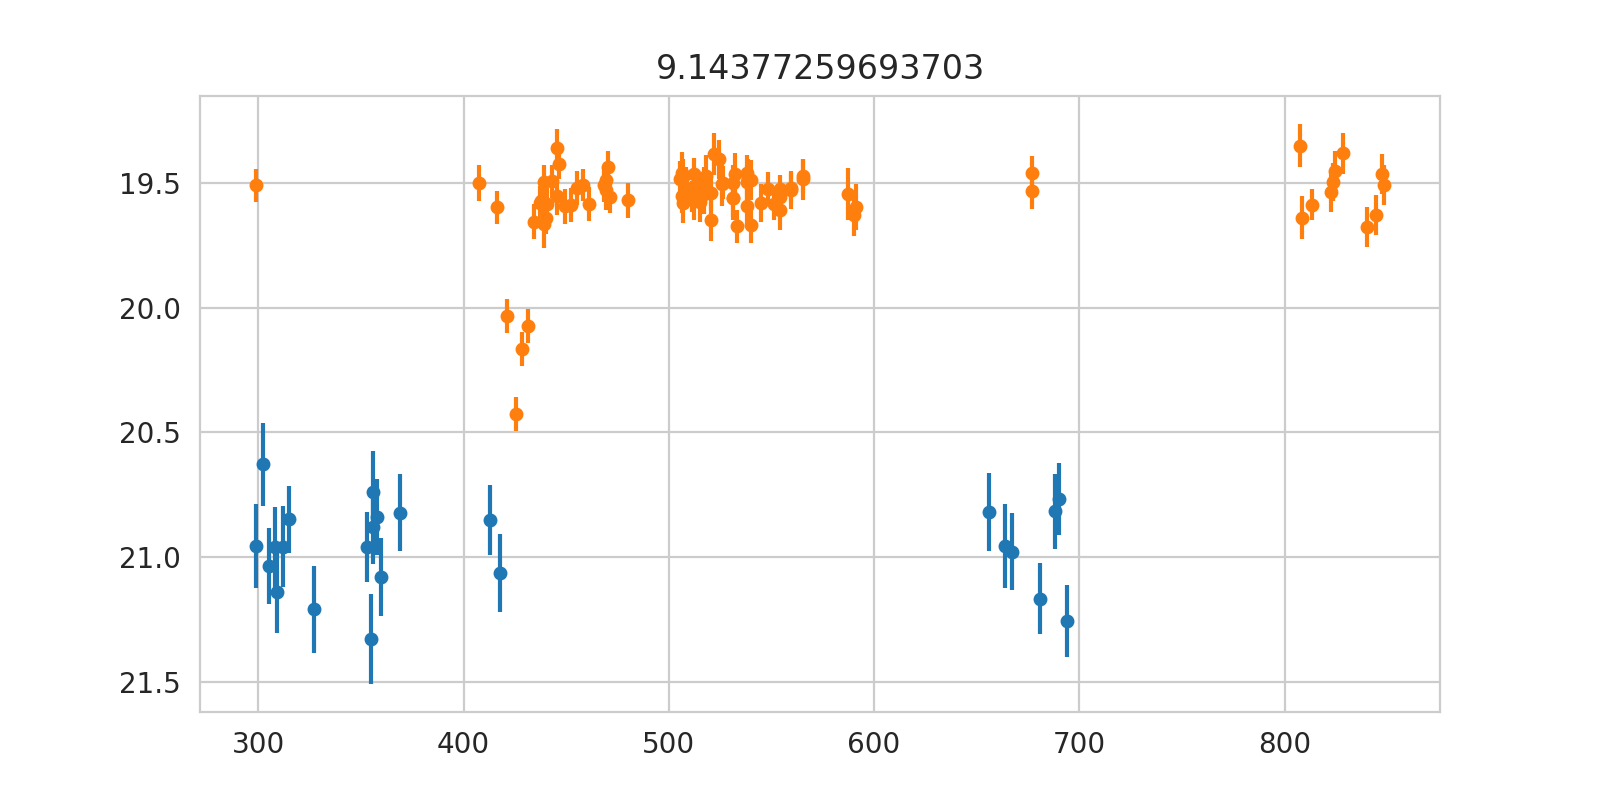

<IPython.core.display.Javascript object>


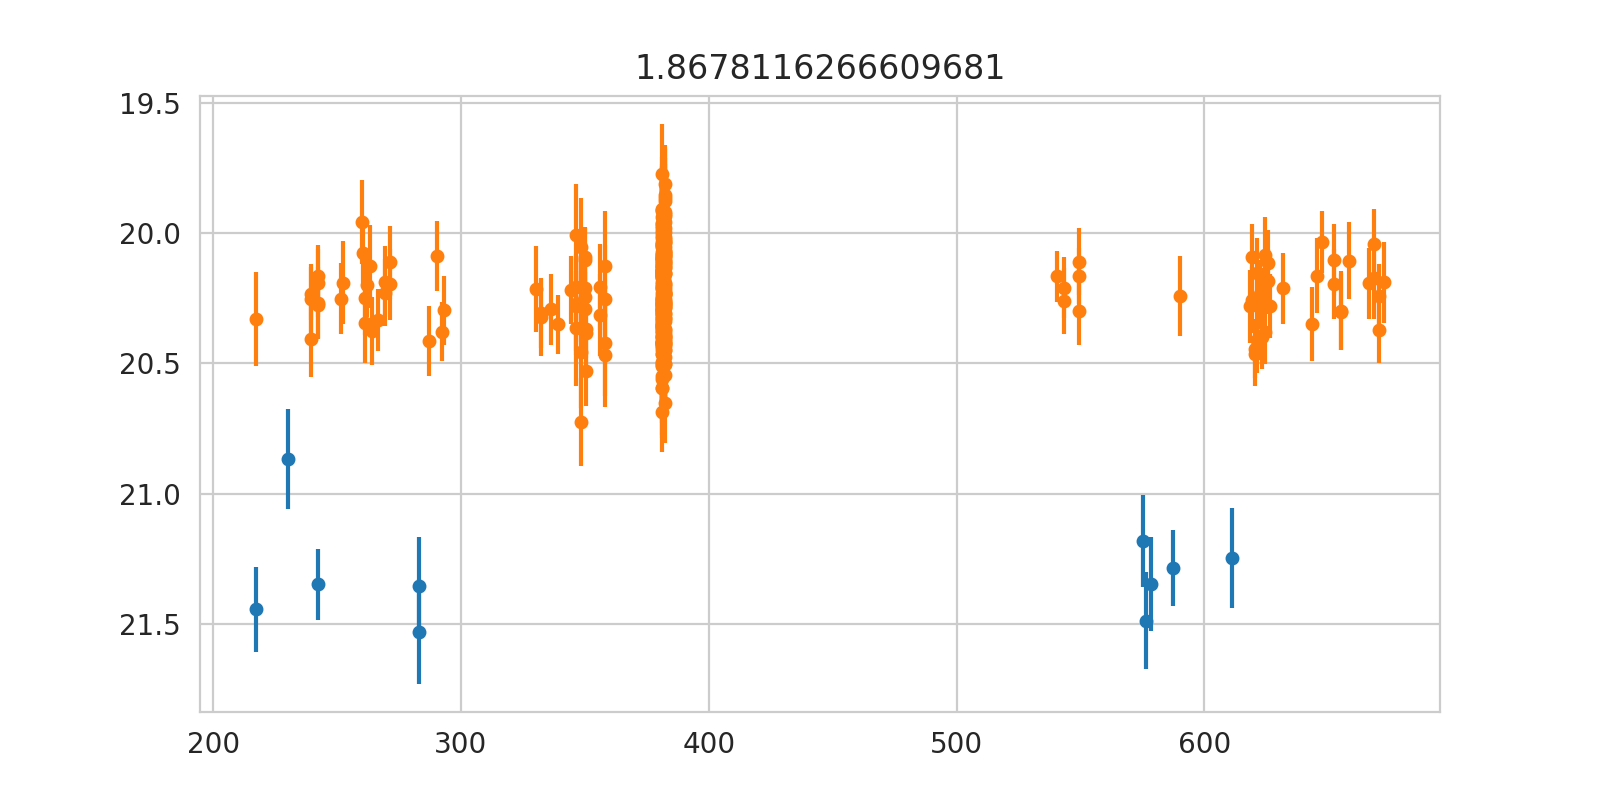

<IPython.core.display.Javascript object>


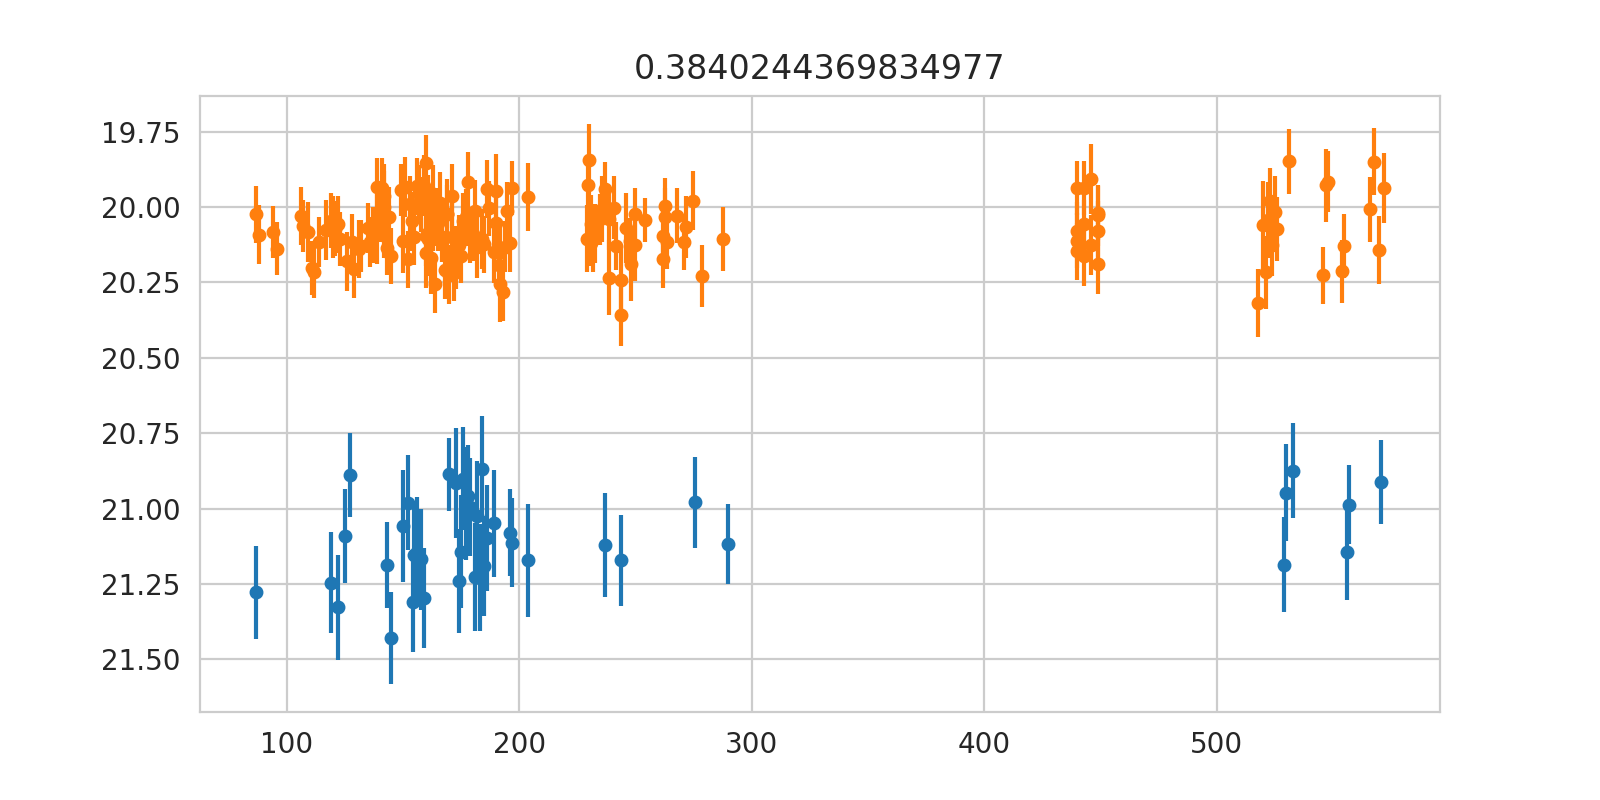

<IPython.core.display.Javascript object>


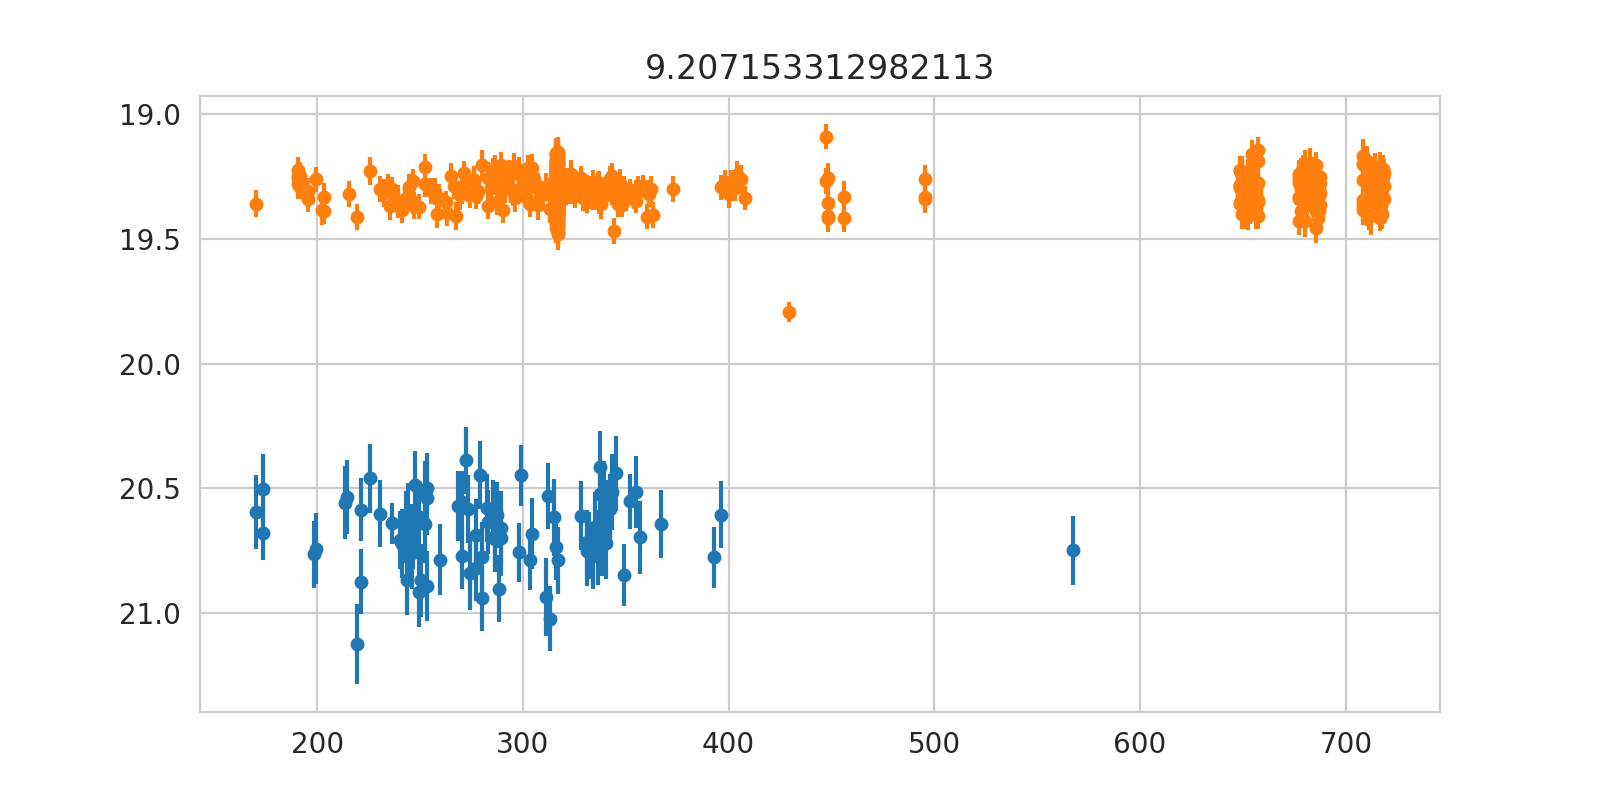

<IPython.core.display.Javascript object>


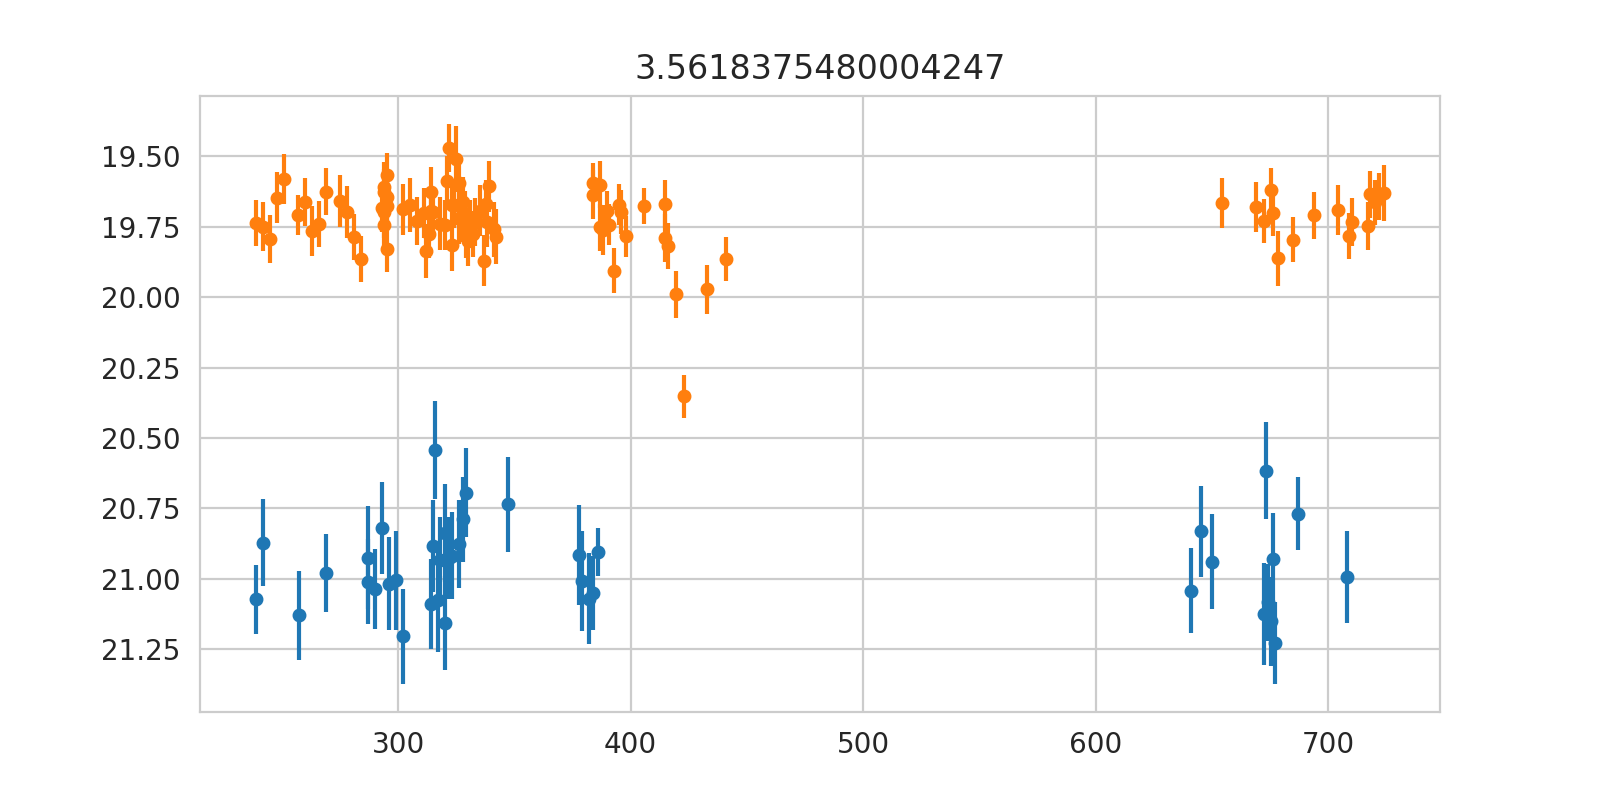

<IPython.core.display.Javascript object>


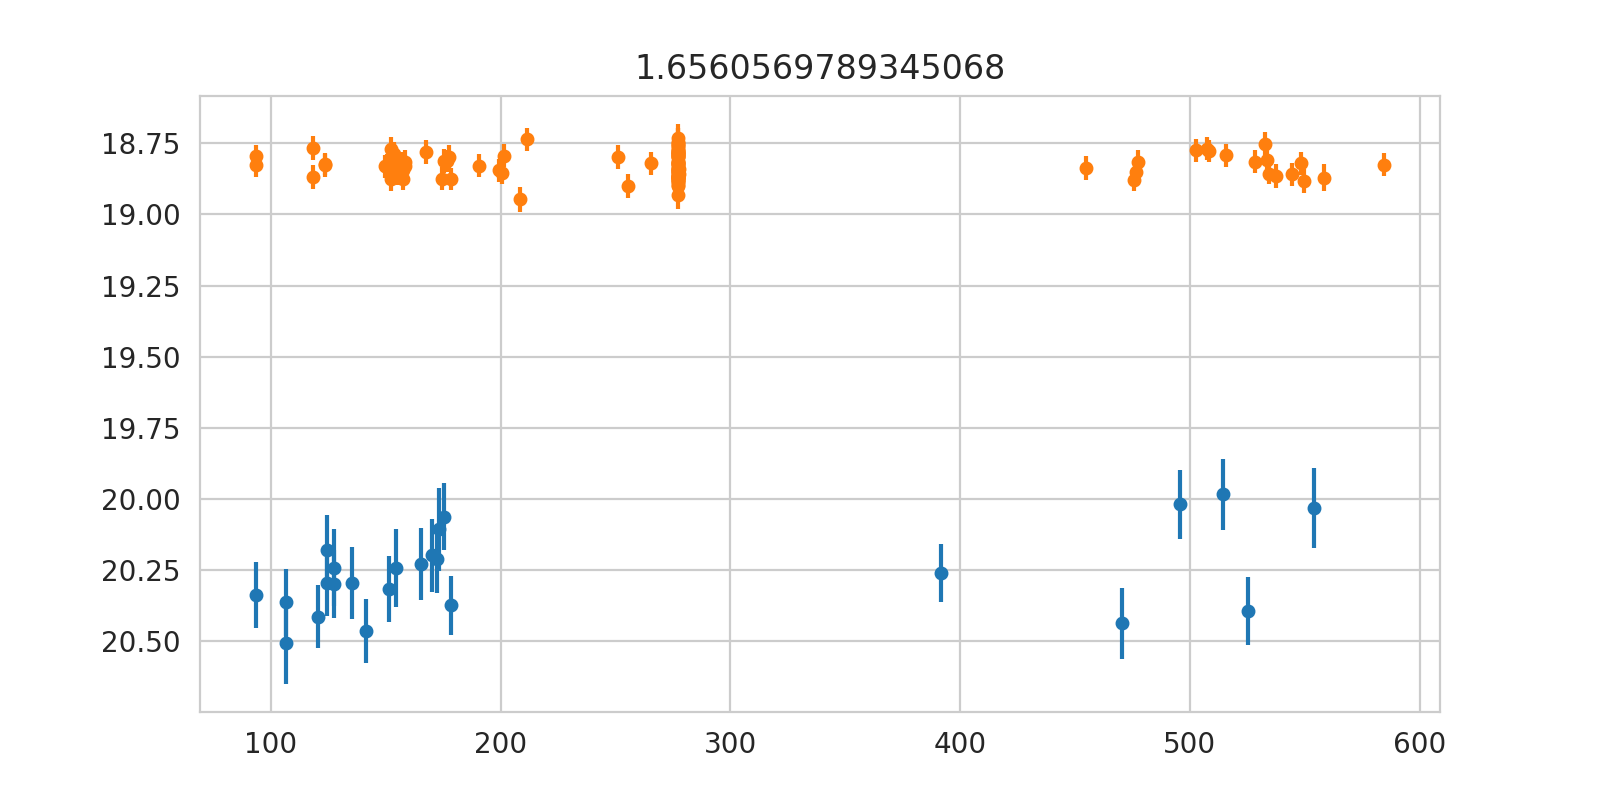

<IPython.core.display.Javascript object>


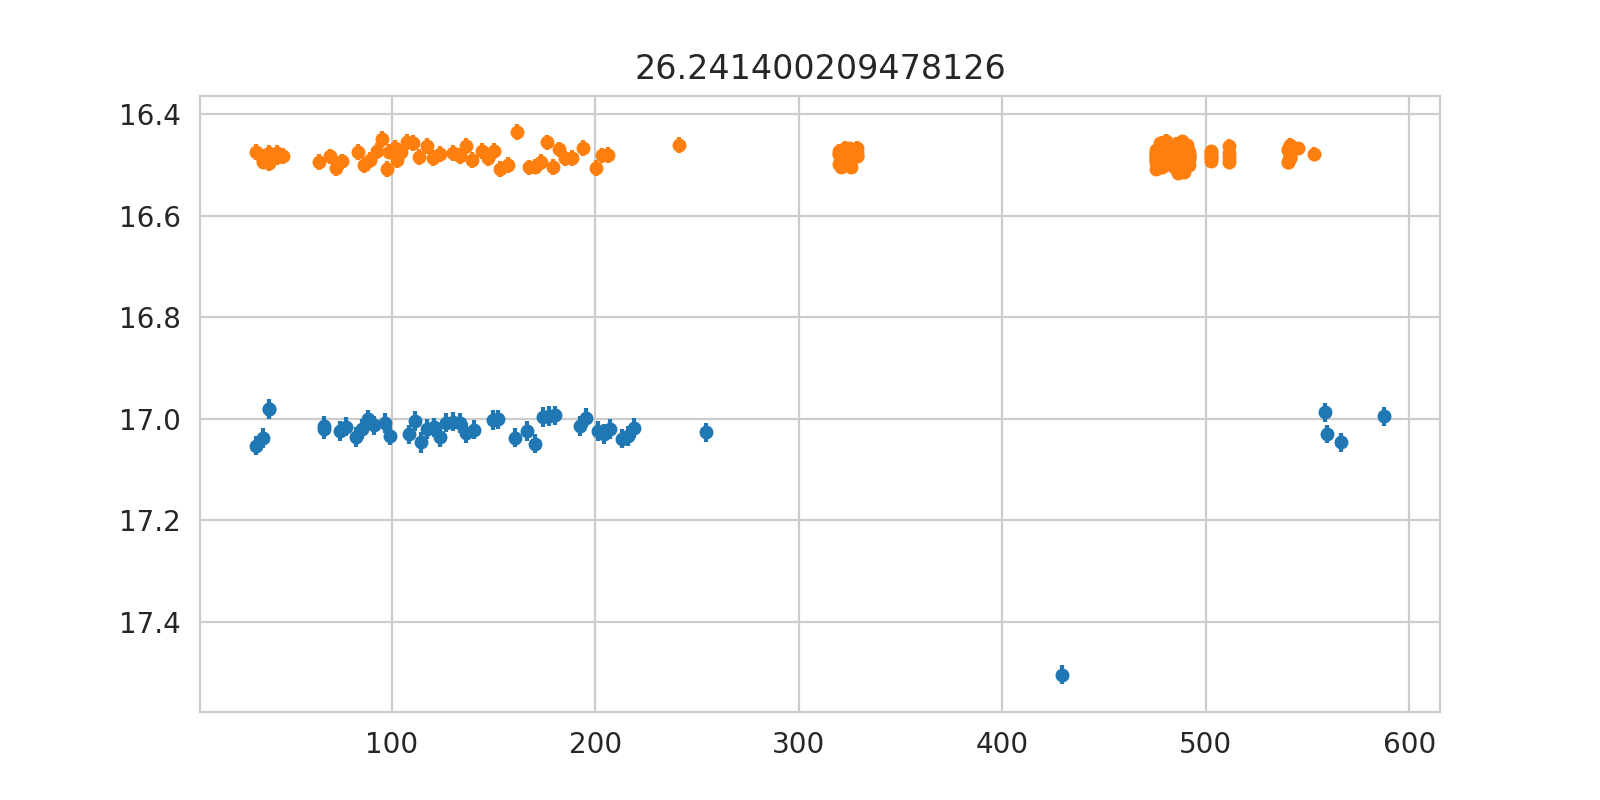

In [185]:
for i in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    lc_all = lc_sim_all[i]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    
    for lc in lc_all:
        ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(res["significance"])


Okay, so that works. Now we can do this for all of our simulated light curves:

In [186]:
res_all = []

for lc_all in lc_sim_all:
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    res_all.append(res)

Let's make a histogram of all the significances:

In [187]:
sig_all = np.array([res["significance"] for res in res_all])

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


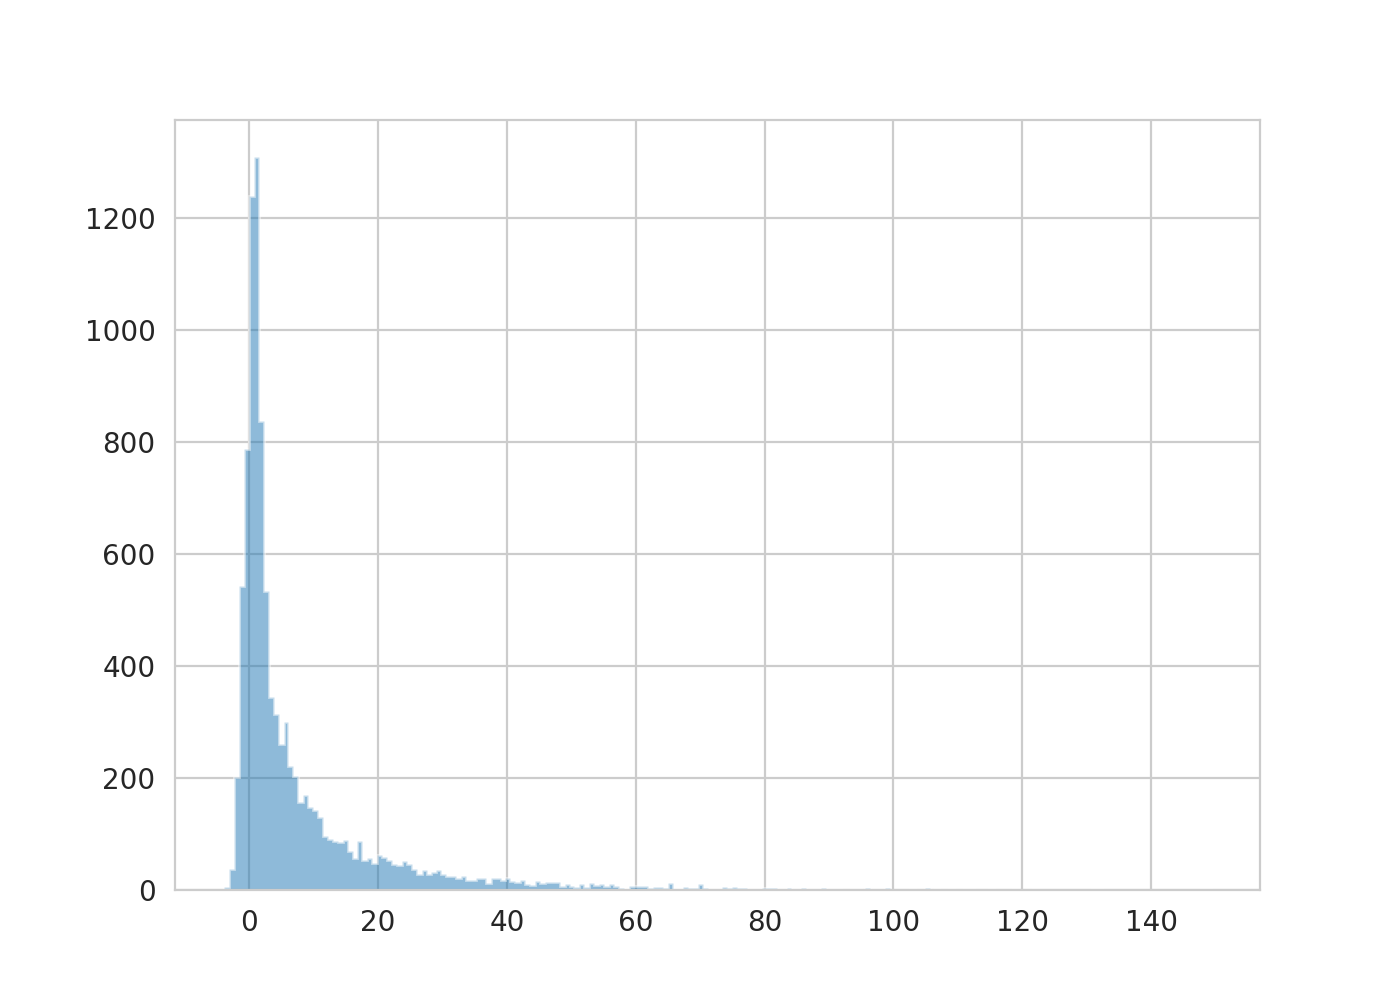

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(sig_all, bins=200, histtype="stepfilled", alpha=0.5);

We are going to look at the high-signal examples.
Let's look at some different examples with different scores:

In [189]:
np.min(sig_all)

-3.876797751107752

In [190]:
np.max(sig_all)

149.2526819247065

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


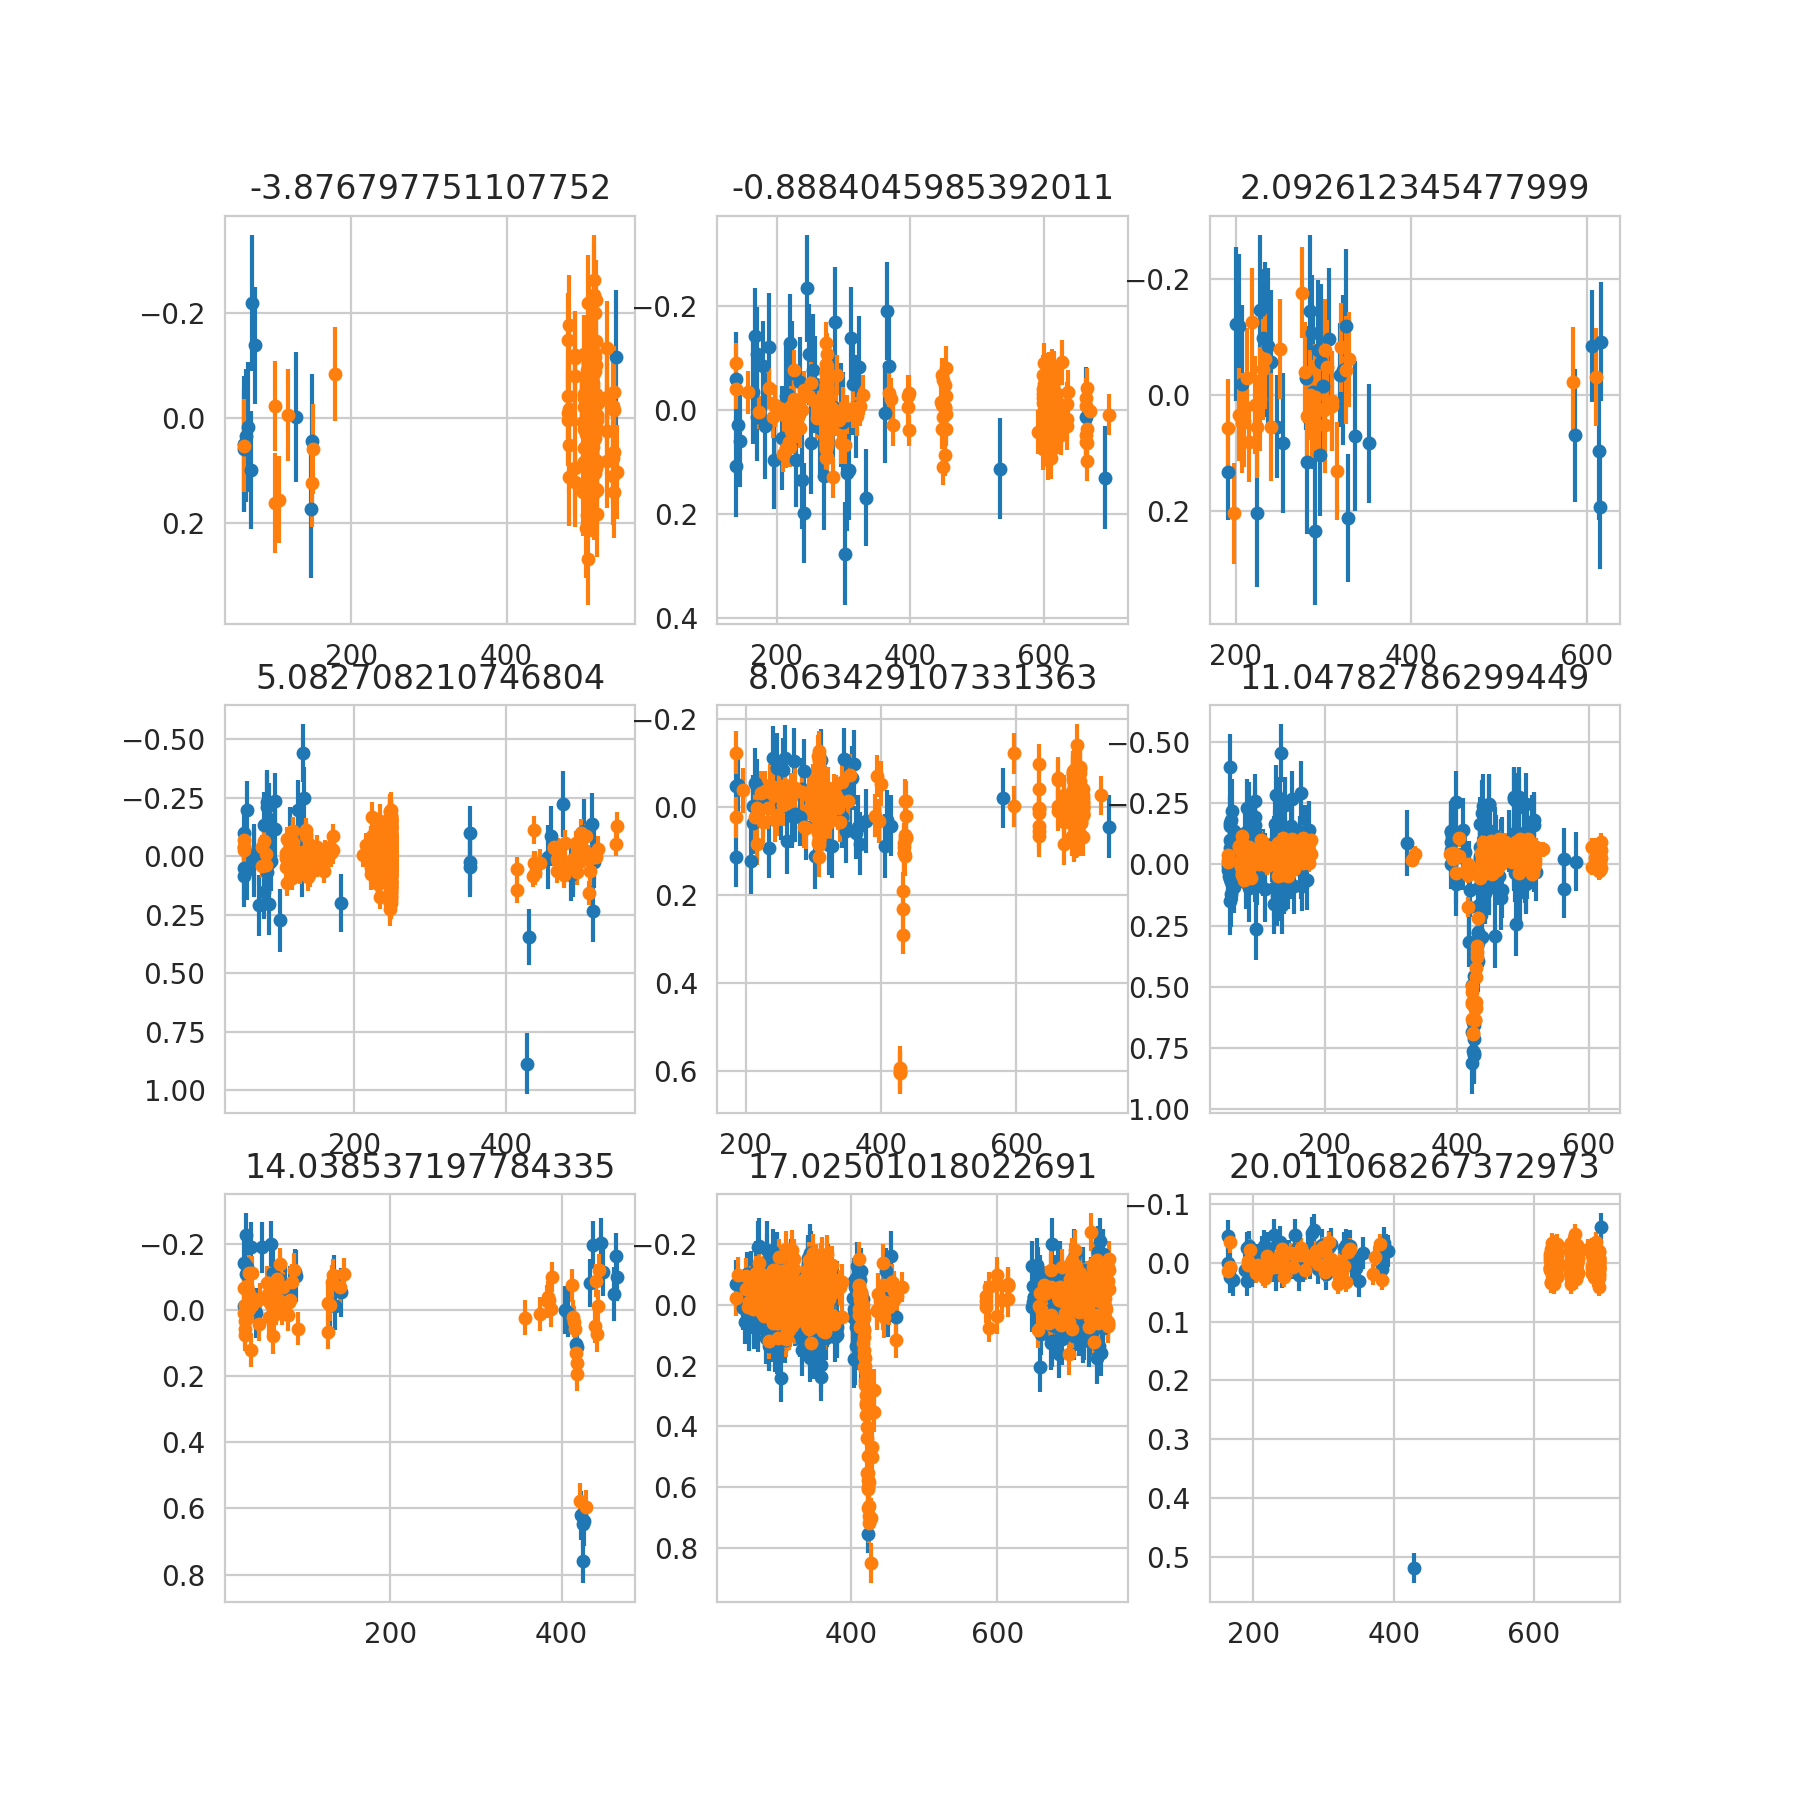

In [191]:
test_scores = np.linspace(np.min(sig_all), 20, 9)

fig, axes = plt.subplots(3, 3, figsize=(9,9))

axes = np.hstack(axes)

sig_all_sorted = np.sort(sig_all)
sig_all_sorted_idx = np.argsort(sig_all)

for i, ts in enumerate(test_scores):
    idx = sig_all_sorted_idx[sig_all_sorted.searchsorted(ts)]
    
    #sig_idx = np.where((sig_all >= ts) & (sig_all <= ts+1))[0]
    #print(sig_idx)
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])



We are going to look for things with a significance > 15 to start with:

In [192]:
np.sum(sig_all > 15.0)

1687

There are 1893 out of 10000 dips that we'd find like this, which is not bad, though I'll admit that the dip is very deep:

In [193]:
sig_mask = (sig_all >= 15.0)

In [194]:
sig_idx = np.where(sig_mask == True)[0]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


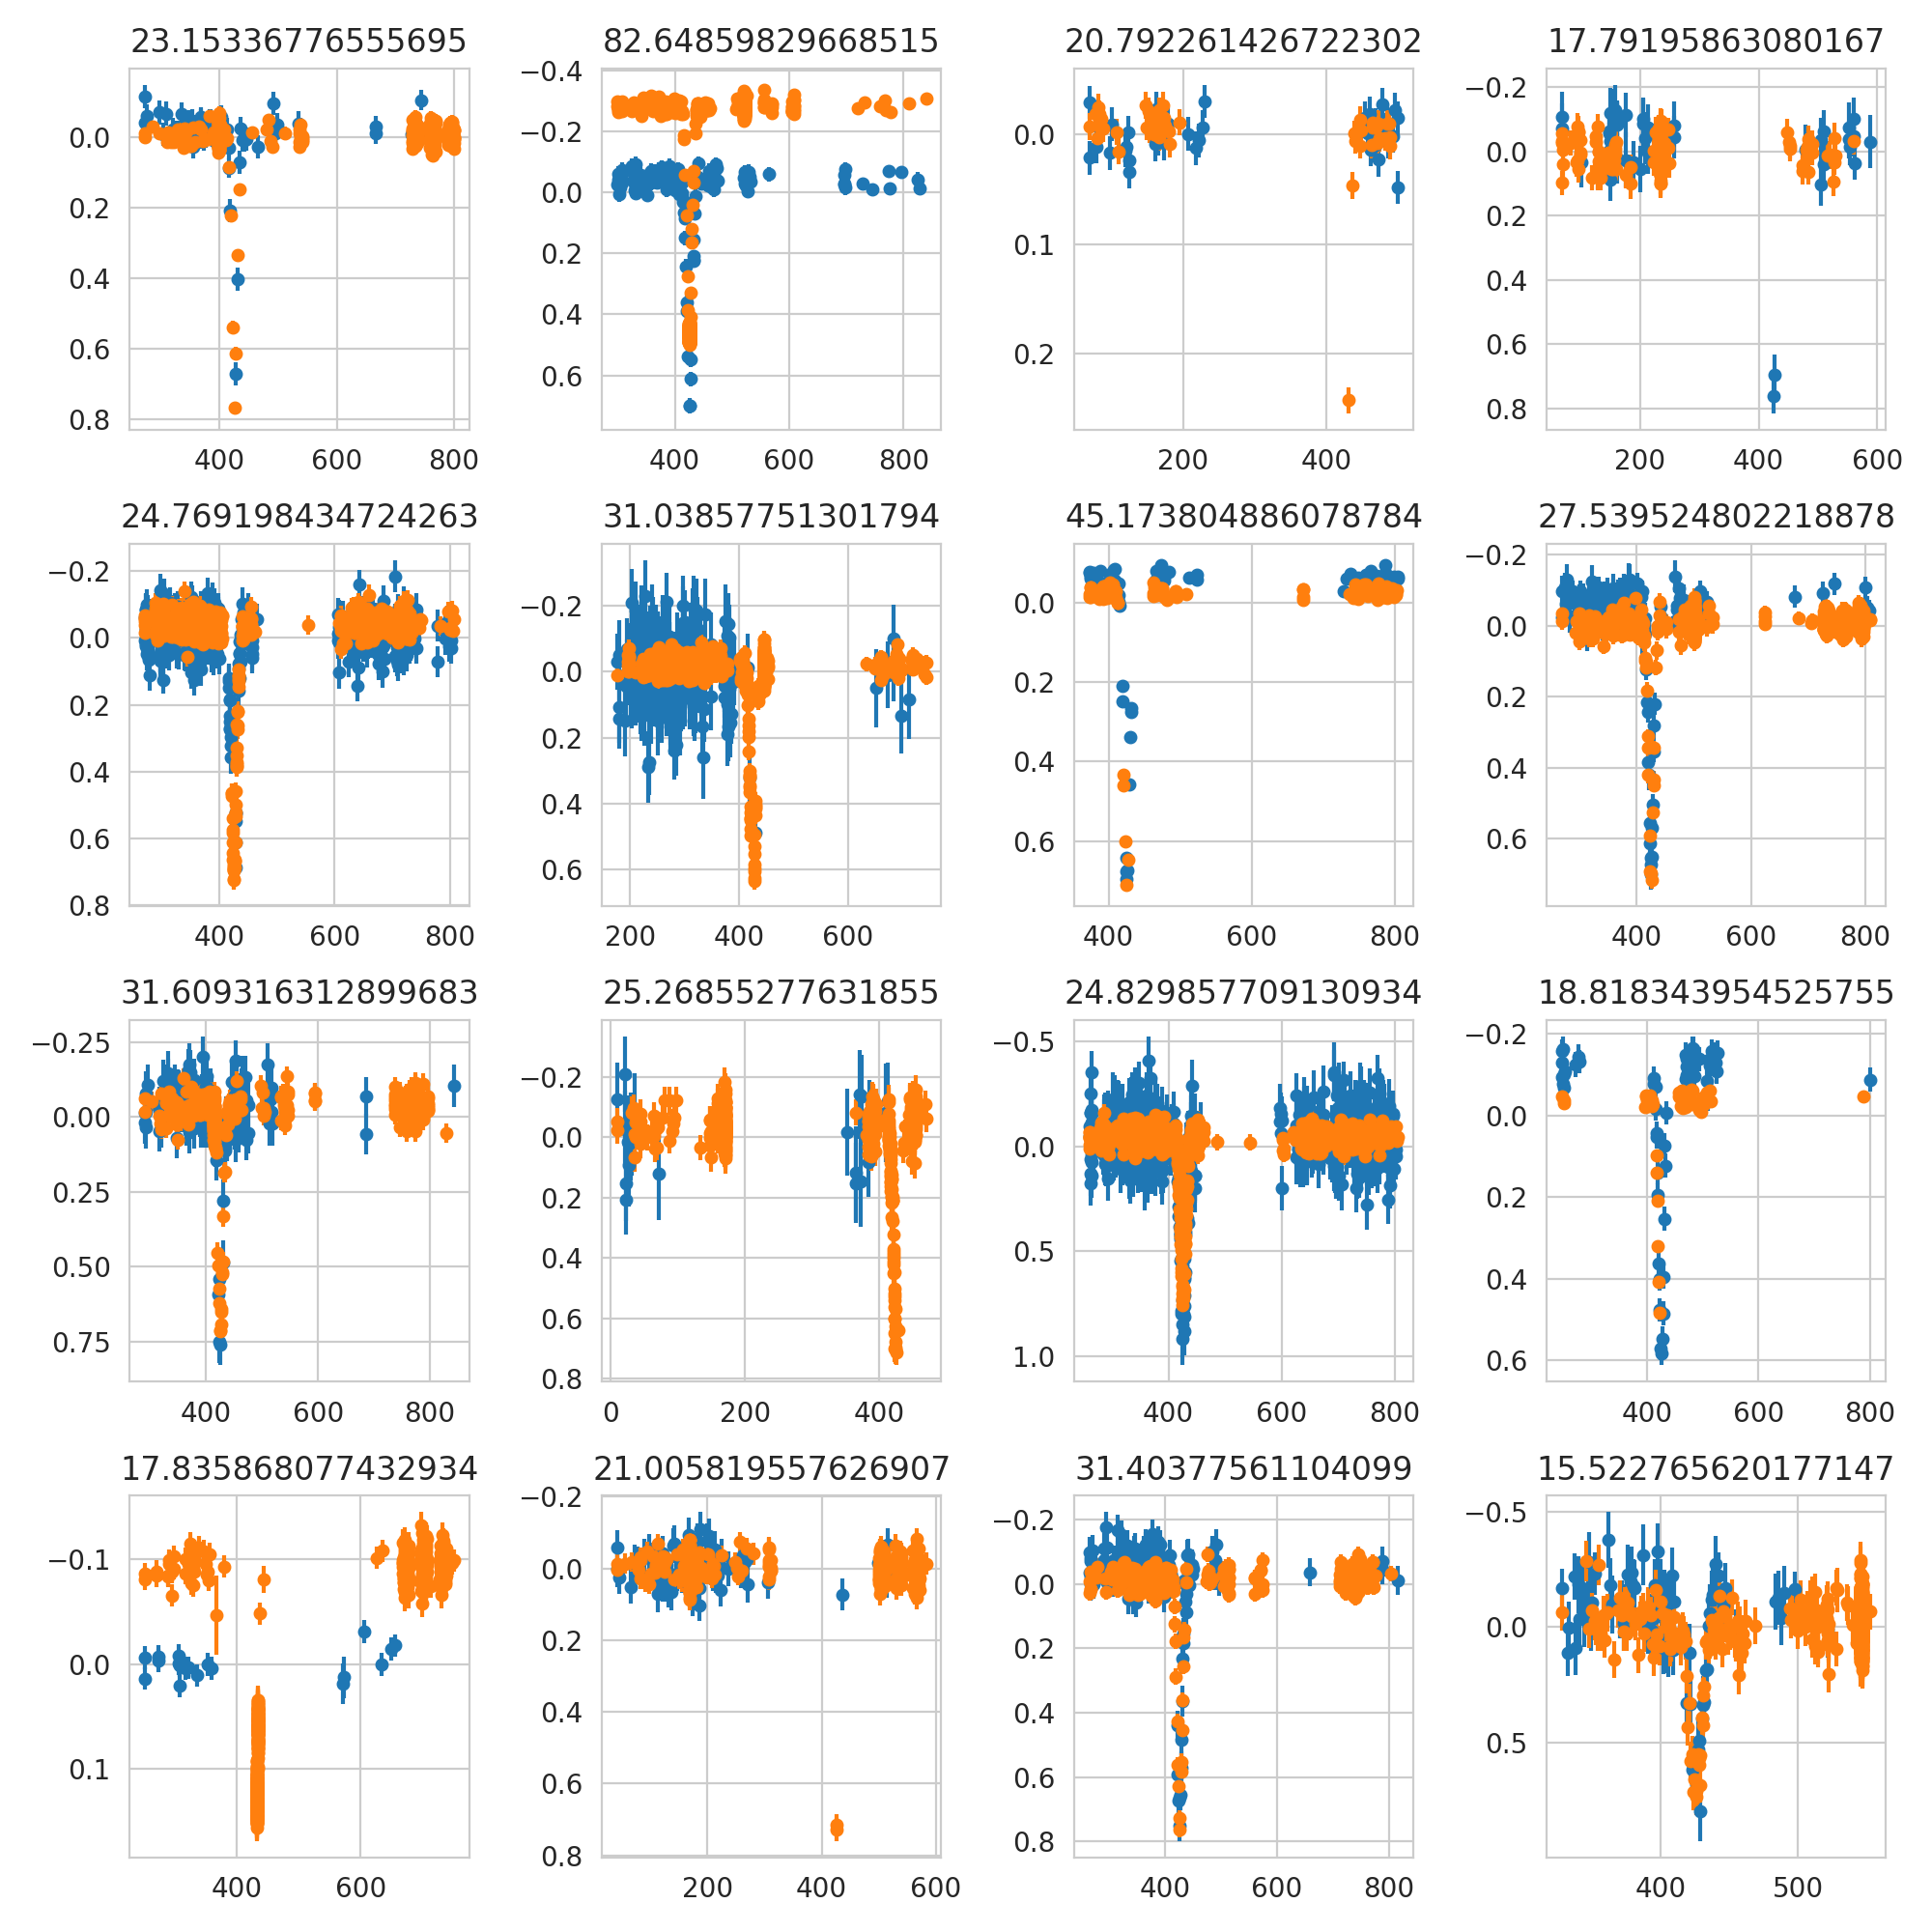

In [195]:
np.random.seed(4000)

idx_test = np.random.choice(sig_idx, replace=False, size=16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

axes = np.hstack(axes)

for i, idx in enumerate(idx_test):
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])


plt.tight_layout()


Let's also use Kyle's decision metrics for whether there's a good dip:

        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        & (sparkfunc.col("dip.significant_width") >= 1)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap") < 2.)

First, we're going to make the list of dictionaries with the dip search results into a DataFrame:

In [196]:
res_df = pd.DataFrame(res_all)

In [197]:
res_df.head()

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
0,0.323510,0.195459,1.655128,208.161430,208.827190,213.028948,4.867518,201.283390,216.283390,1.000235,1.000326,0.002676,28,2,0.75,4.000940
1,7.234431,0.692069,10.453338,419.540824,425.438108,431.193432,11.652608,406.604537,444.185360,3.000705,1.094772,0.009685,11,10,0.00,9.802304
2,0.539654,0.288081,1.873273,93.857686,95.354470,97.907270,4.049584,87.283732,102.283732,4.801128,0.980524,0.001862,0,0,1.00,0.000000
3,8.996401,0.983883,9.143773,420.643167,426.349684,433.296934,12.653767,406.432517,446.383557,4.200987,0.947867,0.000000,4,4,0.00,10.002351
4,3.952849,2.116300,1.867812,368.454147,374.538133,380.013720,11.559573,368.454147,383.454147,18.111003,0.880855,0.000000,0,0,1.00,0.000000


In [198]:
dips = res_df[(res_df["significant_observation_count"] >= 3) &
                     (res_df["core_not_significant_fraction"] <= 0.2) &
                     (res_df["significant_width"] >= 1) &
                     (res_df["significance"] >= 5) &
                     (res_df["ref_pull_std"] < 1.5) &
                     (res_df["ref_large_pull_fraction"] < 0.1) &
                     (res_df["max_gap"] < 2.)
                    ]

In [199]:
dips.head()

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
39,8.149085,0.232242,35.088753,417.984581,425.528470,433.542781,15.558200,402.626916,448.415257,1.800423,0.991044,0.004425,67,65,0.000000,15.003526
270,7.733311,0.450002,17.185065,418.288466,425.385022,431.763900,13.475433,404.994360,446.526349,1.200282,0.951285,0.002463,24,23,0.000000,13.003056
287,8.001230,0.353002,22.666238,417.526382,425.490476,432.733462,15.207079,405.723209,445.119054,1.800423,1.024061,0.003210,39,34,0.025641,14.003291
350,8.430929,0.181878,46.354829,417.682505,425.409214,433.027210,15.344705,405.173525,445.154236,1.800423,1.006785,0.004141,56,56,0.000000,13.803244
362,8.383011,0.141477,59.253436,418.612991,425.734720,434.181280,15.568290,401.141426,450.625240,1.800423,0.967587,0.006652,82,82,0.000000,15.003526


I want to make a function that does this, for ease of convenience, and so that 
I can easily change things:

In [200]:
def identify_dips(res_df):
    """
    Identify dips in the results based on criteria that Kyle 
    developed.
    
    Parameters
    ----------
    res : pandas.DataFrame
        A DataFrame with the outcomes of dip searches 
        across multiple simulations 
    
    Returns
    -------
    dips : pandas.DataFrame
        A DataFrame with the results
    """
    dips = res_df[(res_df["significant_observation_count"] >= 3) &
                     (res_df["core_not_significant_fraction"] <= 0.2) &
                     (res_df["significant_width"] >= 1) &
                     (res_df["significance"] >= 5) &
                     (res_df["ref_pull_std"] < 1.5) &
                     (res_df["ref_large_pull_fraction"] < 0.1) &
                     (res_df["max_gap"] < 2.)
                    ]
    
    return dips

In [201]:
dips = identify_dips(res_df)

In [202]:
dips.head()

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
39,8.149085,0.232242,35.088753,417.984581,425.528470,433.542781,15.558200,402.626916,448.415257,1.800423,0.991044,0.004425,67,65,0.000000,15.003526
270,7.733311,0.450002,17.185065,418.288466,425.385022,431.763900,13.475433,404.994360,446.526349,1.200282,0.951285,0.002463,24,23,0.000000,13.003056
287,8.001230,0.353002,22.666238,417.526382,425.490476,432.733462,15.207079,405.723209,445.119054,1.800423,1.024061,0.003210,39,34,0.025641,14.003291
350,8.430929,0.181878,46.354829,417.682505,425.409214,433.027210,15.344705,405.173525,445.154236,1.800423,1.006785,0.004141,56,56,0.000000,13.803244
362,8.383011,0.141477,59.253436,418.612991,425.734720,434.181280,15.568290,401.141426,450.625240,1.800423,0.967587,0.006652,82,82,0.000000,15.003526


Let's take a look at some examples:

In [203]:
len(dips)

125

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


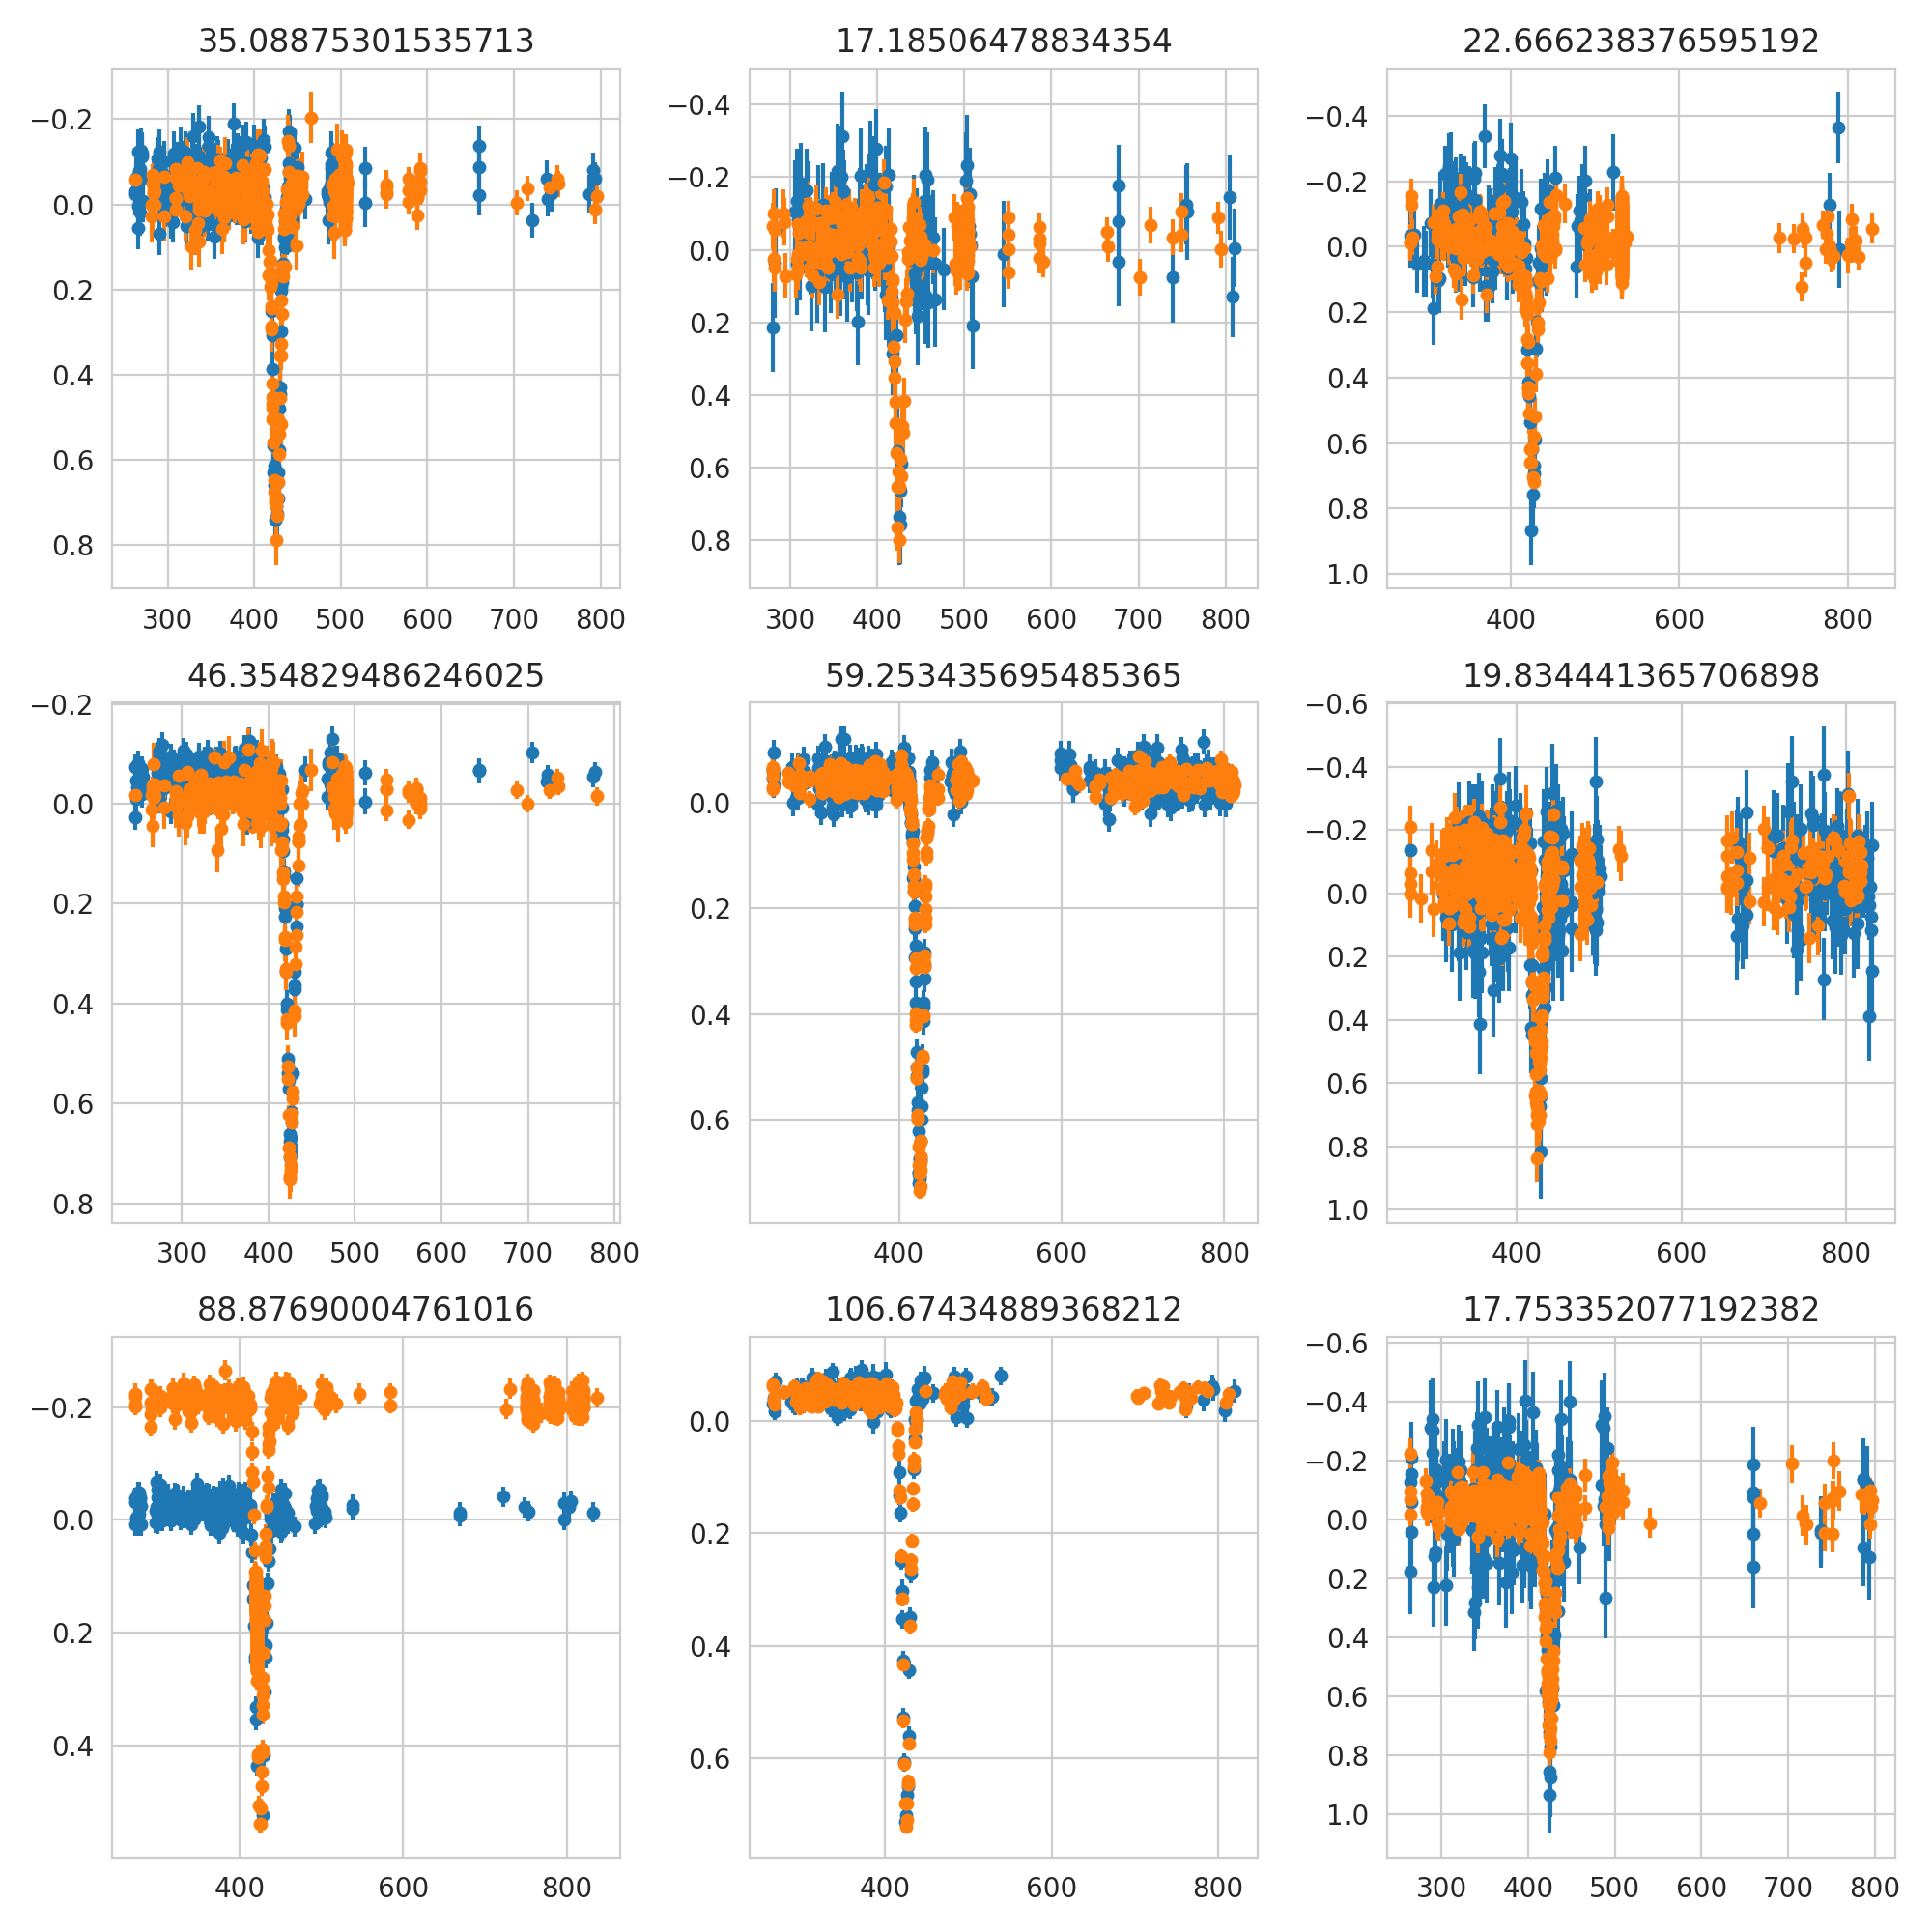

In [204]:
np.random.seed(4000)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i in range(9):
    idx = list(dips.index)[i]
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])


plt.tight_layout()



## Systematic Search

Now we should look systematically across dip widths and dip lengths, but for that we need some kind of criterion whether there is a dip or not:

In [205]:
def simulate_lightcurves(time, flux, nbands=1, cadence=None, npoints=None, 
                         err=0.02, mean_mag=12.0):
    
    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
        
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")

    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")

        
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
        
    if np.size(err) == 1:
        err = np.array([err])
        
    if np.size(npoints) == 1:
        npoints = np.array([npoints])

    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])
        #print("npoints: " + str(npoints))
        #print("cadence: " + str(cadence))
        
    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            #print("i: " + str(i))
            #print("time.shape[0]: " + str((time.shape[0])))
            #print("npoints[i]: " + str(npoints[i]))
                  
            idx = np.sort(np.random.choice(np.arange(time.shape[0]), replace=False, size=npoints[i]))
        else:
            cad = cadence[i]
            idx = time.searchsorted(cad)

        new_time = time[idx]
        new_flux = flux[idx]
        
        #print('len(new_time): ' + str(len(new_time)))
        #print("len(new_flux): " + str(len(new_flux)))
        #print('npoints[i]: ' + str(npoints[i]))
        #print("err[i]: "+ str(err[i]))
        #print('mean_mag[i]: ' + str(mean_mag[i]))
        #print("random points: " + str(len(np.random.normal(mean_mag[i], err[i], size=npoints[i]))))
        mag = -2.5*np.log10(new_flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]
            
        lc = lk.LightCurve(time=new_time, 
                                   flux=mag, 
                                   flux_err=magerr)
        lc_all.append(lc)
        
    return lc_all

In [206]:
def run_simulations(ztf_cadence, nsims, width, depth, tseg=851, coverage=5):
        nztf = len(ztf_cadence)
        
        time, flux = simulate_dip_flux(tseg, coverage, width, depth)


        lc_sims_all, res_all = [], []
        for k in range(nsims):
            idx = np.random.randint(0, nztf, size=1)
            #print("idx: " + str(idx))

            ztf_lc = get_ztf_lightcurve(ztf_cadence, idx[0])
            max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
            min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])

            max_start = tseg - max_time

            tstart = 0.0 #np.random.uniform(0, max_start, size=1)

            c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
            c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

            cadences = np.array([c1, c2])
            nbands = 2
            mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
            magerr_g = ztf_lc["magerr_g"]
            magerr_r = ztf_lc["magerr_r"]
            magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
            magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
            err = np.array([magerr_g, magerr_r])

            lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                                          err=err, mean_mag=mean_mag)

            lc_sims_all.append(lc_all)

            t_all = [lc.time for lc in lc_all]
            mag_all = [lc.flux for lc in lc_all]
            magerr_all = [lc.flux_err for lc in lc_all]

            res = measure_dip(t_all, mag_all, magerr_all)
            res_all.append(res)
            
            
        res_df = pd.DataFrame(res_all)

        dips = identify_dips(res_df)
        
        return lc_sims_all, res_df, dips


Let's try this:

In [207]:
nsims = 5
w = 5
d = 0.5
coverage = 5

lc_all_width, res_all_width, dips = run_simulations(ztf_cadence, nsims, w, d, 
                                                    tseg=tseg, coverage=coverage)

In [208]:
widths = [1, 2, 3, 4, 5, 7, 10, 20]
depths = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]

print(len(widths))
print(len(depths))

8
8


I also made a script with all these functions, so let's see whether that works:

In [255]:
from simulations import identify_dips, simulate_lightcurves_from_function, run_simulations, simulate_dip_flux, get_ztf_lightcurve

In [256]:
widths = [1, 2, 4, 5, 8, 10, 20, 30]
depths = [0.01, 0.1, 0.2, 0.3, 0.4]
coverage = 5
nsims = 10000

lc_all_sims = []
res_all_sims = []
res_bool_sims = []

dip_fraction = np.zeros((len(depths), len(widths)))

for i, d in enumerate(depths):
    print("i: " + str(i))
    res_all_depth = []
    lc_all_depth = []
    res_bool_depth = []
    for j, w in enumerate(widths):
        #print("j: " + str(j))        
        
        lc_all_width, res_all_width, dips = run_simulations(ztf_cadence, nsims, w, d, 
                                                            tseg=tseg, coverage=coverage)
        res_bool = pd.DataFrame(np.array([(res_all_width["significant_observation_count"] >= 3),
                        (res_all_width["core_not_significant_fraction"] <= 0.2),
                        (res_all_width["significant_width"] >= 1),
                        (res_all_width["significance"] >= 5),
                        (res_all_width["ref_pull_std"] < 1.5),
                        (res_all_width["ref_large_pull_fraction"] < 0.1),
                        (res_all_width["max_gap"] < 2.)]).T,
                        columns = ["significant_observation_count", "core_not_significant_fraction",
                                 "significant_width", "significance", "ref_pull_std", "ref_large_pull_fraction",
                                 "max_gap"]
                       )



        res_bool_depth.append(res_bool)
        lc_all_depth.append(lc_all_width)
        res_all_depth.append(res_all_width)
        
        dip_fraction[i, j] = len(dips)/len(res_all_width)
        
    res_all_sims.append(res_all_depth)
    lc_all_sims.append(lc_all_depth)
    res_bool_sims.appendres_bool_depth()
        

i: 0
i: 1
i: 2
i: 3
i: 4


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


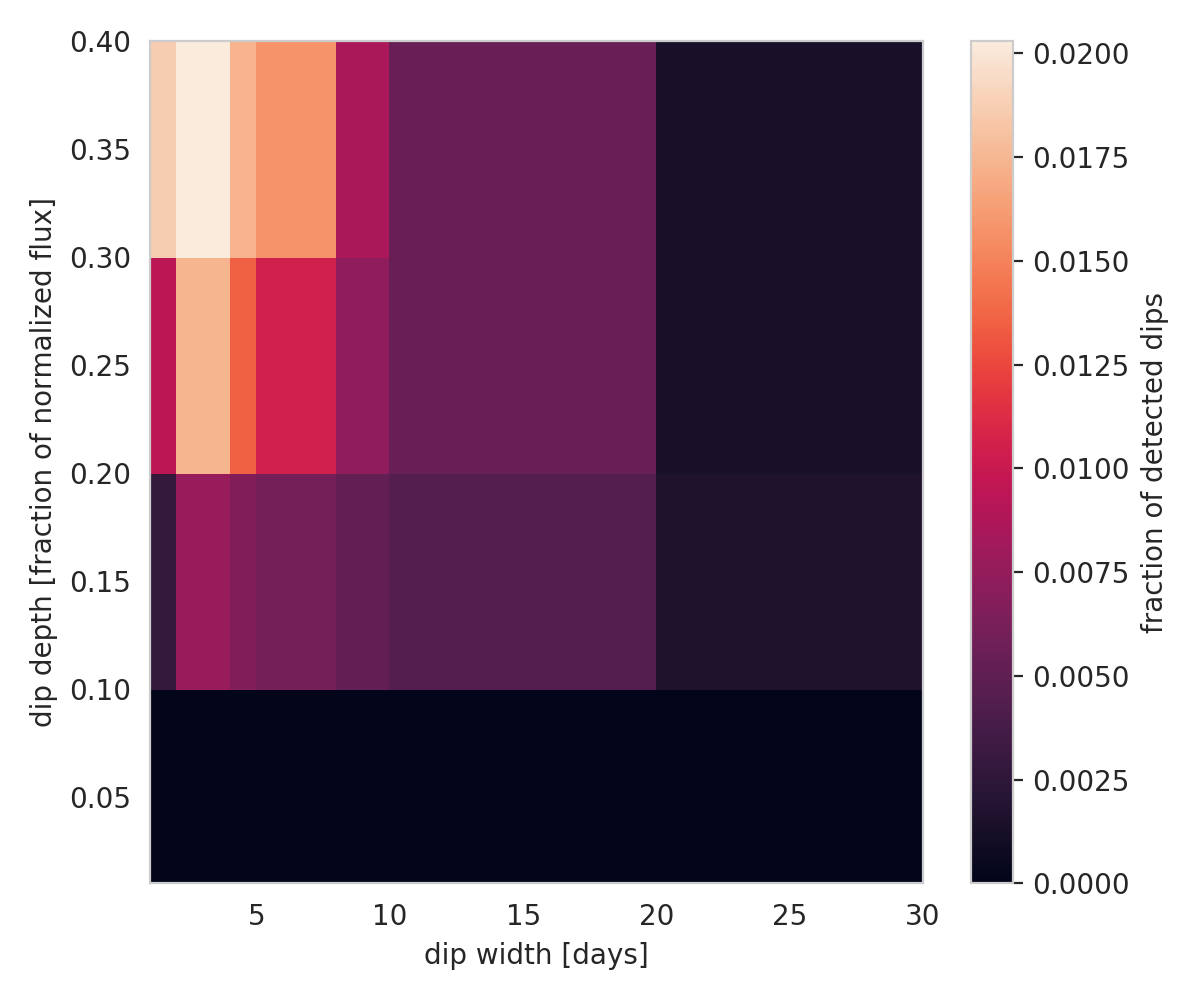

In [259]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

im = ax.pcolormesh(widths, depths, dip_fraction)
cbar = fig.colorbar(im)
cbar.set_label('fraction of detected dips')

ax.set_xlabel("dip width [days]")
ax.set_ylabel("dip depth [fraction of normalized flux]")
plt.tight_layout()

It is surprising that we aren't sensitive to longer dips, so I'm going to plot some examples:

In [260]:
depths = [0.01, 0.1, 0.2, 0.3, 0.4]
widths = [1, 2, 4, 5, 8, 10, 20, 30]



In [261]:
res_long = res_all_sims[-1][1]
lc_all_long = lc_all_sims[-1][1]
dips = identify_dips(res_long)

In [262]:
len(dips)

280

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


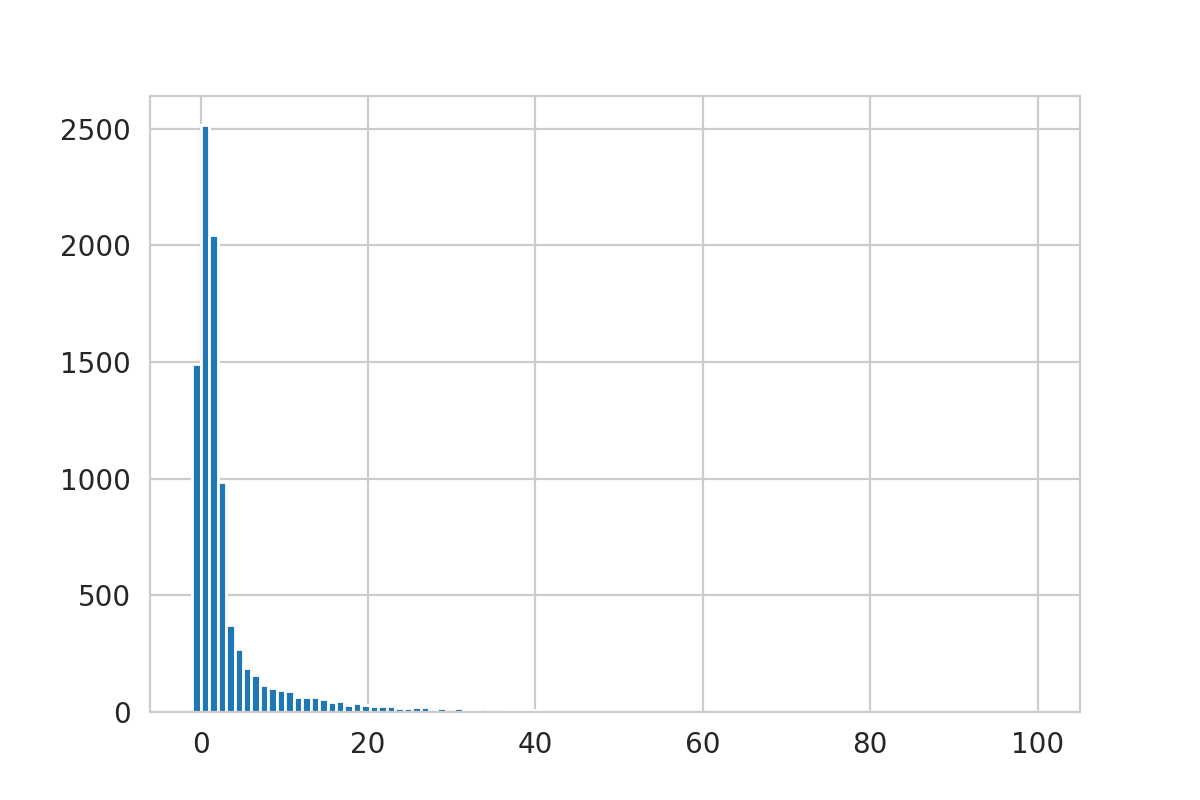

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(res_long["significance"], bins=100, range=[-1,100]);

In [264]:
dips

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
61,2.513836,0.077172,32.574602,57.795668,60.941581,64.046033,6.250365,51.413678,70.470564,1.880278,0.972249,0.000865,23,23,0.0,6.087604
86,2.566636,0.161678,15.874993,161.326213,165.004056,167.921343,6.595130,155.820098,174.002849,1.059734,0.993945,0.005272,11,10,0.0,5.080648
104,2.360316,0.387821,6.086095,78.473348,82.806931,85.464135,6.990787,72.565375,93.168261,1.992049,0.982623,0.000000,11,6,0.0,3.112604
116,2.874105,0.194785,14.755257,168.814366,172.260498,178.181093,9.366727,157.852474,186.670199,1.939039,0.981230,0.006270,14,12,0.0,5.931146
122,2.243973,0.442565,5.070383,129.540850,132.918595,134.818620,5.277770,124.981308,140.854104,1.042095,1.022129,0.020134,5,4,0.0,3.037153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,2.557693,0.065017,39.338665,113.870949,117.274920,120.361916,6.490967,107.977459,126.655692,1.983808,0.952226,0.000000,17,17,0.0,6.008252
9716,2.657989,0.123303,21.556541,108.488156,111.351548,114.335024,5.846868,103.724751,118.724751,1.987569,1.030119,0.002398,8,8,0.0,3.988183
9832,2.678766,0.432951,6.187224,442.960097,446.130830,449.249188,6.289092,433.257411,458.202731,1.901956,1.002009,0.002692,9,7,0.0,4.796377
9903,2.871954,0.368169,7.800635,154.955199,157.761880,161.092583,6.137384,149.950477,165.742093,1.936609,0.998223,0.002639,5,5,0.0,4.111667


In [265]:
lc_all_dip = lc_all_long[dips.index[0]]
lc_all_nodip = lc_all_long[res_long[res_long["significance"] > 10].index[10]]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


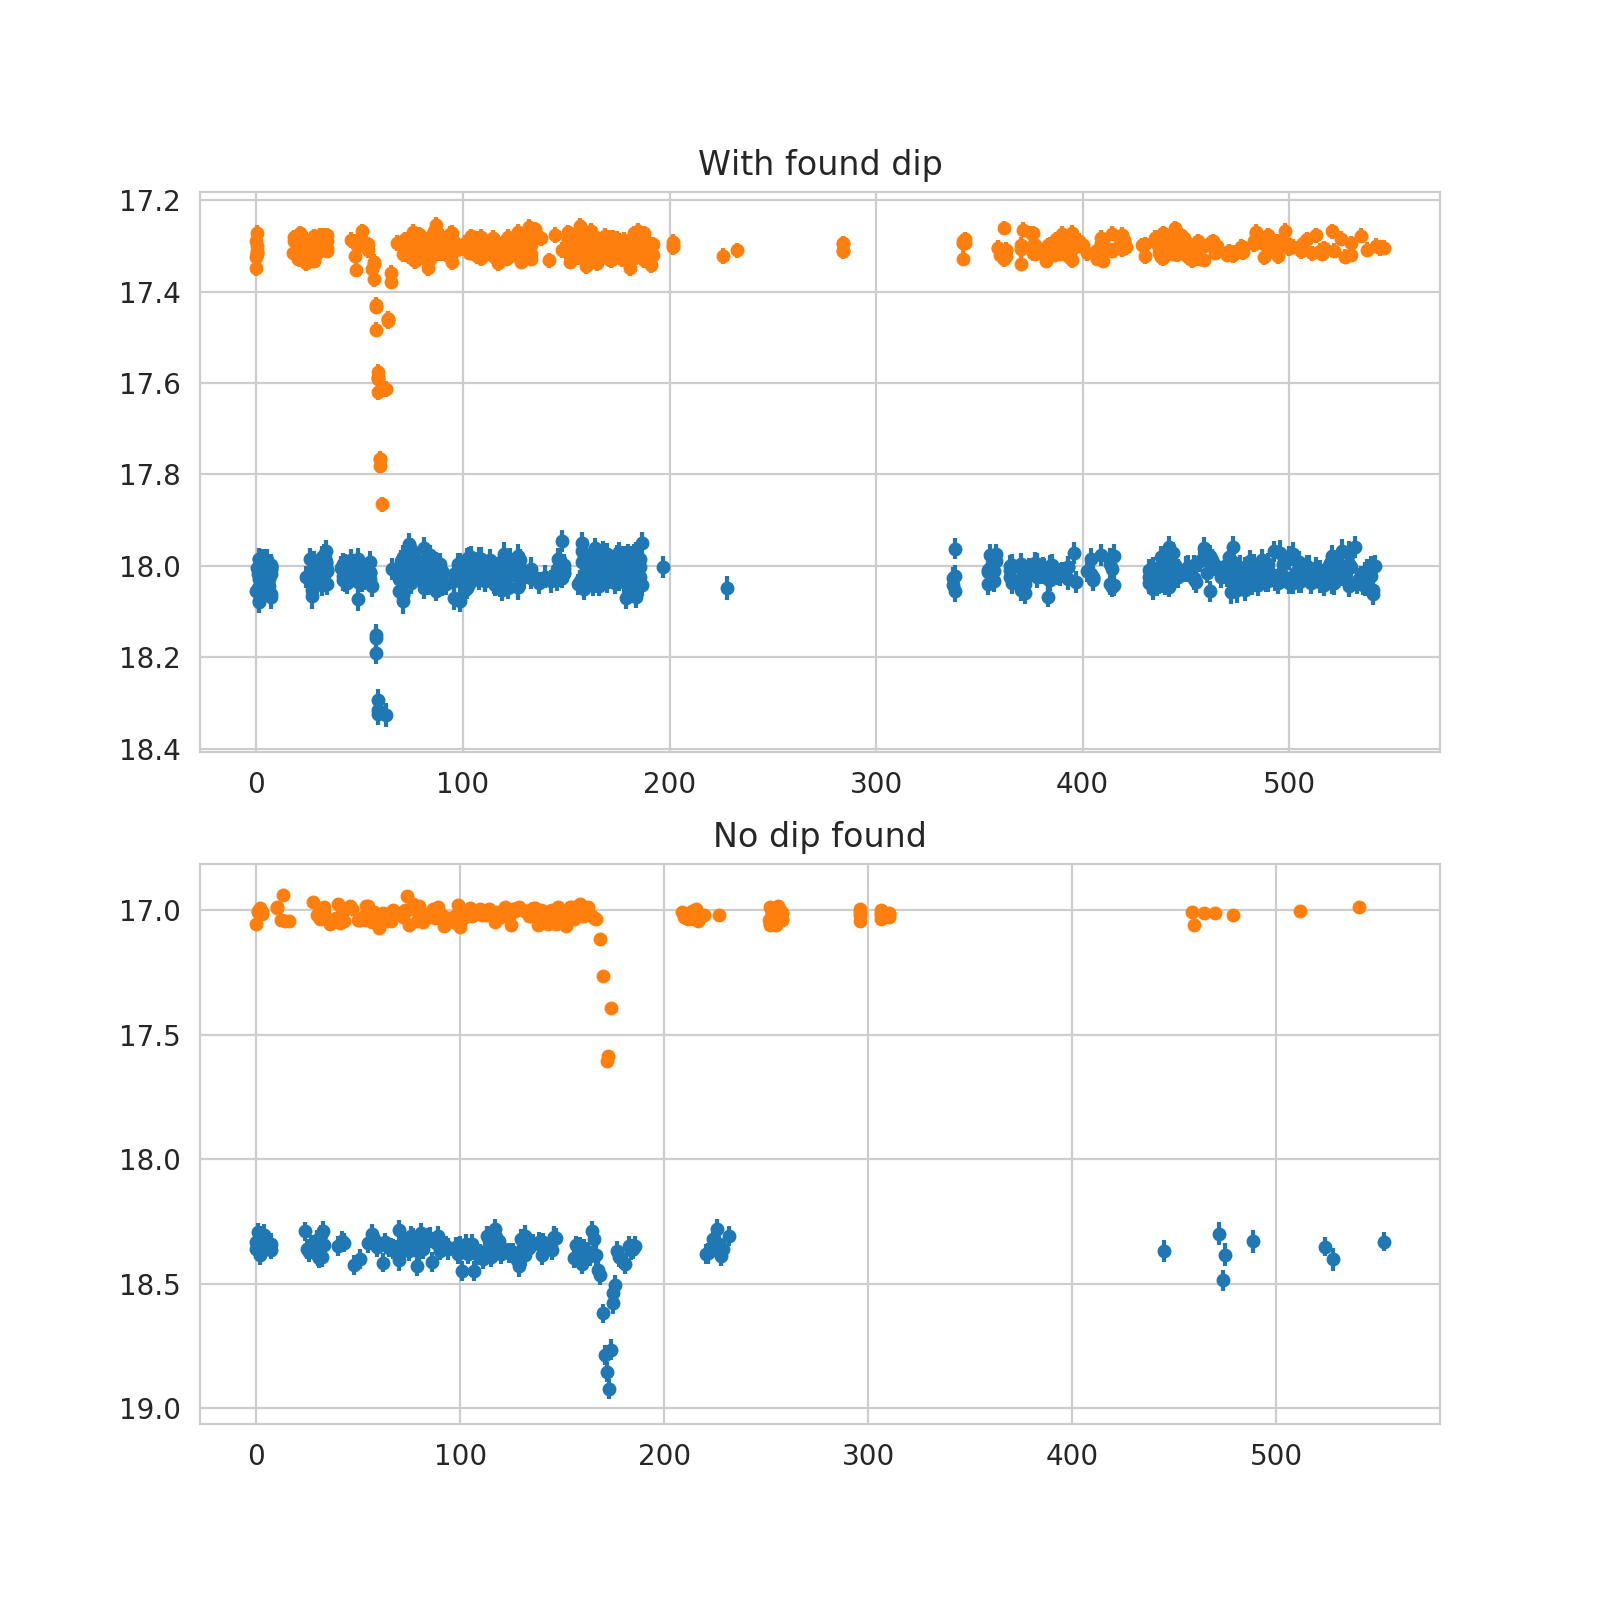

Text(0.5, 1.0, 'No dip found')

In [266]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

for lcd, lcn in zip(lc_all_dip, lc_all_nodip):
    ax1.errorbar(lcd.time, lcd.flux, yerr=lcd.flux_err, fmt="o", markersize=4)
    ax2.errorbar(lcn.time, lcn.flux, yerr=lcn.flux_err, fmt="o", markersize=4)
    
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.set_ylim(ax2.get_ylim()[::-1])

ax1.set_title("With found dip")
ax2.set_title("No dip found")

In [267]:
for idx in res_long[res_long["significance"] > 10].index:
    lc_all = lc_all_long[idx]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    if res["significant_observation_count"] < 3:
        print("simulation %i"%idx)
        print("significant observation count: %.2f (should be >= 3 )"%res["significant_observation_count"])
    if res["core_not_significant_fraction"]  > 0.2:
        print("simulation %i"%idx)
        print("core_not_significant_fraction: %.2f (should be <= 0.2)"%res["core_not_significant_fraction"])
    if res["significant_width"] < 1:
        print("simulation %i"%idx)
        print("significant_width: %.2f (should be >= 1)"%res["significant_width"])
    if res["significance"] < 5:
        print("simulation %i"%idx)
        print("significance: %.2f (should be >= 5)"%res["significance"])
    if res["ref_pull_std"] >= 1.5:
        print("simulation %i"%idx)
        print("ref_pull_std: %.2f (should be < 1.5)"%res["ref_pull_std"])
    if res["ref_large_pull_fraction"] >= 0.1:
        print("simulation %i"%idx)
        print("ref_large_pull_fraction: %.4f (should be < 0.1)"%res["ref_large_pull_fraction"])
    if res["max_gap"] >= 2.0: 
        print("simulation %i"%idx)
        print("max_gap: %.2f (should be < 2.)"%res["max_gap"])
    print()

simulation 5
max_gap: 2.96 (should be < 2.)

simulation 17
significant observation count: 1.00 (should be >= 3 )
simulation 17
significant_width: 0.00 (should be >= 1)
simulation 17
max_gap: 26.13 (should be < 2.)

simulation 52
significant observation count: 1.00 (should be >= 3 )
simulation 52
significant_width: 0.00 (should be >= 1)
simulation 52
max_gap: 24.83 (should be < 2.)


simulation 70
max_gap: 17.99 (should be < 2.)

simulation 72
significant observation count: 2.00 (should be >= 3 )
simulation 72
max_gap: 3.98 (should be < 2.)

simulation 76
max_gap: 4.98 (should be < 2.)

simulation 81
max_gap: 4.02 (should be < 2.)


simulation 103
max_gap: 2.97 (should be < 2.)




simulation 137
significant_width: 0.31 (should be >= 1)
simulation 137
max_gap: 7.06 (should be < 2.)

simulation 169
max_gap: 5.98 (should be < 2.)

simulation 172
significant_width: 0.98 (should be >= 1)
simulation 172
max_gap: 23.83 (should be < 2.)

simulation 196
max_gap: 5.99 (should be < 2.)

simulatio

simulation 2616
max_gap: 5.77 (should be < 2.)

simulation 2622
max_gap: 12.35 (should be < 2.)


simulation 2656
max_gap: 6.22 (should be < 2.)

simulation 2671
max_gap: 3.01 (should be < 2.)

simulation 2673
max_gap: 9.45 (should be < 2.)

simulation 2701
max_gap: 6.97 (should be < 2.)

simulation 2707
max_gap: 4.64 (should be < 2.)

simulation 2712
max_gap: 2.03 (should be < 2.)

simulation 2718
max_gap: 26.06 (should be < 2.)

simulation 2729
max_gap: 4.02 (should be < 2.)

simulation 2766
significant observation count: 1.00 (should be >= 3 )
simulation 2766
significant_width: 0.00 (should be >= 1)
simulation 2766
max_gap: 33.08 (should be < 2.)

simulation 2780
max_gap: 6.22 (should be < 2.)

simulation 2781
max_gap: 2.06 (should be < 2.)

simulation 2793
max_gap: 30.47 (should be < 2.)


simulation 2798
max_gap: 3.04 (should be < 2.)


simulation 2812
max_gap: 2.11 (should be < 2.)

simulation 2816
max_gap: 7.54 (should be < 2.)

simulation 2825
max_gap: 3.97 (should be < 2.)

si

simulation 4370
max_gap: 23.97 (should be < 2.)

simulation 4373
significant observation count: 1.00 (should be >= 3 )
simulation 4373
significant_width: 0.00 (should be >= 1)
simulation 4373
max_gap: 18.10 (should be < 2.)

simulation 4379
significant observation count: 1.00 (should be >= 3 )
simulation 4379
significant_width: 0.00 (should be >= 1)
simulation 4379
max_gap: 31.66 (should be < 2.)

simulation 4393
max_gap: 6.57 (should be < 2.)

simulation 4397
significant observation count: 1.00 (should be >= 3 )
simulation 4397
significant_width: 0.00 (should be >= 1)
simulation 4397
max_gap: 24.97 (should be < 2.)



simulation 4440
significant observation count: 1.00 (should be >= 3 )
simulation 4440
significant_width: 0.00 (should be >= 1)
simulation 4440
max_gap: 27.42 (should be < 2.)

simulation 4449
max_gap: 28.14 (should be < 2.)

simulation 4462
max_gap: 5.03 (should be < 2.)

simulation 4468
max_gap: 2.96 (should be < 2.)

simulation 4493
max_gap: 4.00 (should be < 2.)

simu

simulation 5782
max_gap: 7.00 (should be < 2.)

simulation 5795
max_gap: 4.94 (should be < 2.)

simulation 5797
significant observation count: 2.00 (should be >= 3 )
simulation 5797
max_gap: 13.48 (should be < 2.)

simulation 5805
max_gap: 3.78 (should be < 2.)


simulation 5813
max_gap: 8.85 (should be < 2.)

simulation 5863
max_gap: 2.94 (should be < 2.)

simulation 5899
significant observation count: 2.00 (should be >= 3 )
simulation 5899
significant_width: 0.00 (should be >= 1)
simulation 5899
max_gap: 39.00 (should be < 2.)

simulation 5906
max_gap: 2.92 (should be < 2.)


simulation 5926
significant observation count: 1.00 (should be >= 3 )
simulation 5926
significant_width: 0.00 (should be >= 1)
simulation 5926
max_gap: 31.97 (should be < 2.)

simulation 5944
max_gap: 3.02 (should be < 2.)

simulation 5961
max_gap: 2.95 (should be < 2.)




simulation 6003
max_gap: 2.95 (should be < 2.)

simulation 6019
max_gap: 7.87 (should be < 2.)

simulation 6027
max_gap: 5.97 (should be < 2

simulation 7117
significant observation count: 2.00 (should be >= 3 )
simulation 7117
significant_width: 0.94 (should be >= 1)
simulation 7117
max_gap: 6.66 (should be < 2.)

simulation 7134
max_gap: 3.92 (should be < 2.)

simulation 7136
max_gap: 20.83 (should be < 2.)

simulation 7147
significant observation count: 2.00 (should be >= 3 )
simulation 7147
max_gap: 23.98 (should be < 2.)

simulation 7156
max_gap: 3.21 (should be < 2.)

simulation 7162
significant observation count: 1.00 (should be >= 3 )
simulation 7162
significant_width: 0.00 (should be >= 1)
simulation 7162
max_gap: 7.60 (should be < 2.)

simulation 7181
significant observation count: 1.00 (should be >= 3 )
simulation 7181
significant_width: 0.00 (should be >= 1)
simulation 7181
max_gap: 26.43 (should be < 2.)

simulation 7200
max_gap: 12.90 (should be < 2.)

simulation 7202
significant observation count: 1.00 (should be >= 3 )
simulation 7202
significant_width: 0.00 (should be >= 1)
simulation 7202
max_gap: 18.89 (sh

simulation 9477
significant observation count: 1.00 (should be >= 3 )
simulation 9477
significant_width: 0.00 (should be >= 1)
simulation 9477
max_gap: 22.42 (should be < 2.)

simulation 9478
significant observation count: 2.00 (should be >= 3 )
simulation 9478
max_gap: 3.11 (should be < 2.)

simulation 9479
max_gap: 6.00 (should be < 2.)

simulation 9488
significant observation count: 1.00 (should be >= 3 )
simulation 9488
significant_width: 0.00 (should be >= 1)
simulation 9488
max_gap: 35.49 (should be < 2.)

simulation 9492
max_gap: 3.05 (should be < 2.)

simulation 9494
significant observation count: 2.00 (should be >= 3 )
simulation 9494
max_gap: 28.93 (should be < 2.)


simulation 9506
significant observation count: 1.00 (should be >= 3 )
simulation 9506
significant_width: 0.00 (should be >= 1)
simulation 9506
max_gap: 6.37 (should be < 2.)

simulation 9510
significant observation count: 2.00 (should be >= 3 )
simulation 9510
max_gap: 10.51 (should be < 2.)

simulation 9515
max_

TO DO:

Right now:
* Make the length of the light curve the lifetime of ZTF (done) (DONE)
* throw out observations that have zero or negative errors (DONE)
* Evaluate dip function directly for cadence, rather than make a finely sampled light curve first.
* make function that makes a table of boolean flags so I can explore which criteria fail for which simulations?

Once I've got new info/code from Kyle:
* Get cadences directly from AXS table/spark (Kyle will make notebook)
* simulate widths much more finely (up to 50 days), keep depth the same
* Make recovery plot on a log-axis to look at 1-day, 2-day axis to see what we can say about short dips
* look at examples from all four corners of the plot above, figure out whether are surprising ways in which this fails?
* Check short/deep dips: why is the efficiency 3%? Do those fail in other ways than the cadence missing the dip at all?
* How does the algorithm perform on very short timescales? E.g. a day?
* diagnostic plot: recovery fraction as a function of apparent magnitude?
